<h2><b>Importing libraries</b></h2>

In [190]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error
import math
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

<h2><b>Getting data</b></h2>

In [191]:
histEmbr = web.DataReader('EMBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histOi = web.DataReader('OIBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histMglu = web.DataReader('MGLU3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histAmbv = web.DataReader('ABEV3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histVale = web.DataReader('VALE3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histPetro = web.DataReader('PETR4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histFlry = web.DataReader('FLRY3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histCgas = web.DataReader('CGAS5.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
# histRio = web.DataReader('VVAR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
# histOSX = web.DataReader('BBDC4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [192]:
# historicStock = [histVale, histAzul, histBB, histPetro, histItau, histRio, histOSX]
historicStock = [histEmbr, histOi, histMglu, histAmbv, histBB, histVale, histPetro, histFlry, histCgas]

In [193]:
historicStock[0].head()

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2018-01-02  20.990000  20.230000  20.629999  20.520000  3813300.0  20.389370
2018-01-03  21.600000  20.860001  21.049999  21.299999  9403700.0  21.164400
2018-01-04  22.200001  21.500000  21.500000  21.799999  6597700.0  21.661217
2018-01-05  22.129999  20.650000  21.900000  20.650000  8980400.0  20.518539
2018-01-08  21.170000  20.500000  21.059999  20.700001  4798500.0  20.568220

In [194]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [195]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [196]:
calculate_daily_inflation(monthlyInflation2018)

<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [197]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [198]:
calculate_lines()

In [199]:
def plot_emas(stocks, inflation=False):
    for stock in stocks:
        plt.figure(figsize = (14,10))
        plt.plot(stock["ShortEMA"], label="ShortEMA")
        plt.plot(stock["LongEMA"], label="LongEMA")
        plt.plot(stock["Close"], label="Close", alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valores/Preço')
        plt.title("EMAs")
        plt.show()

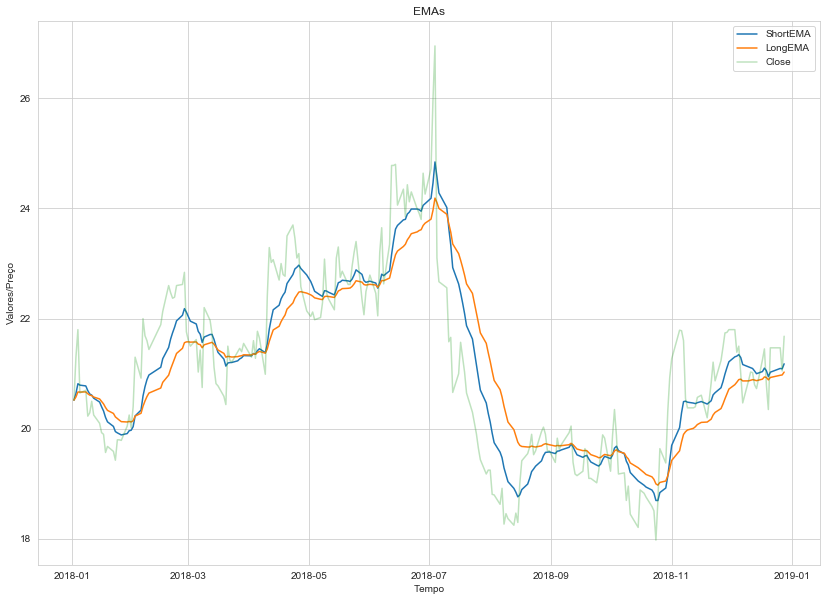

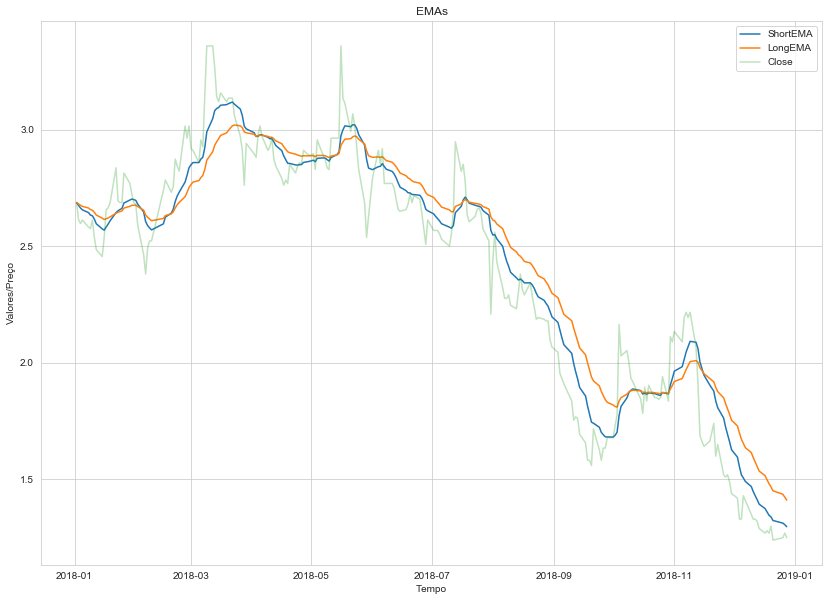

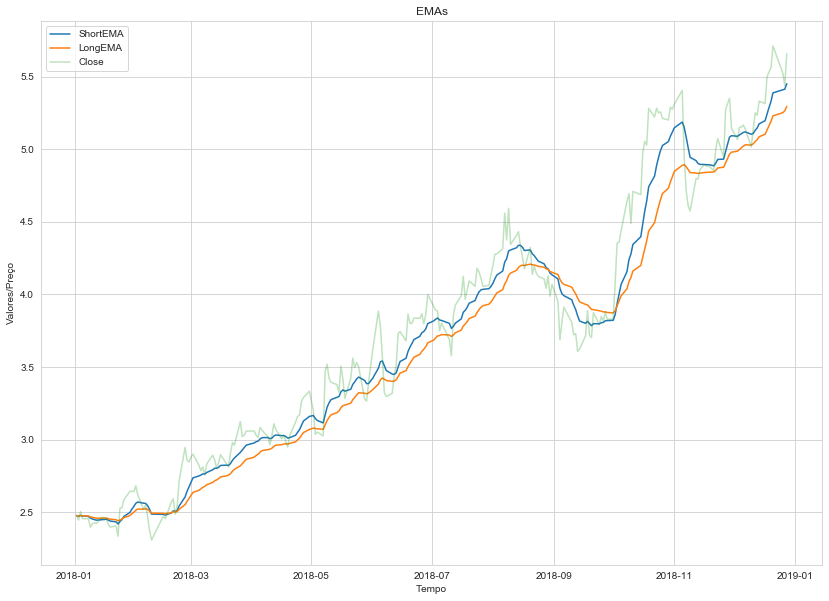

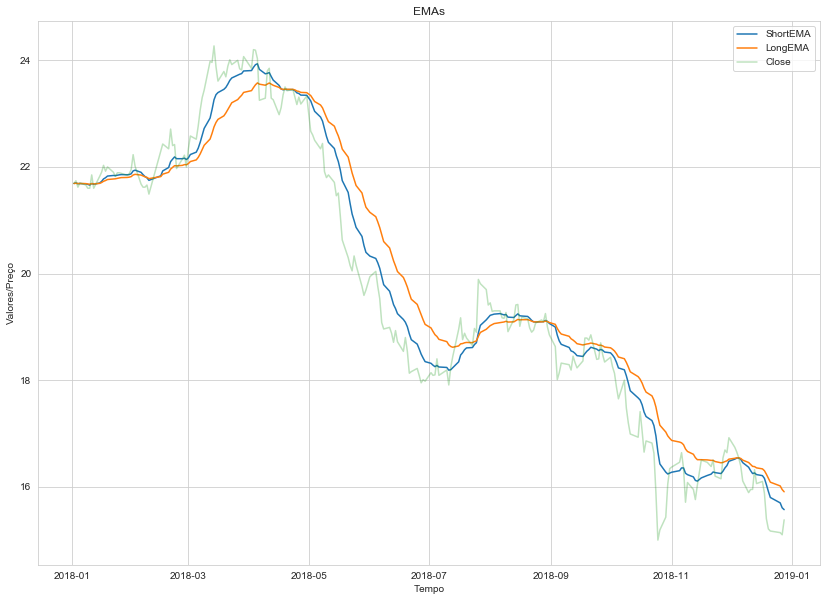

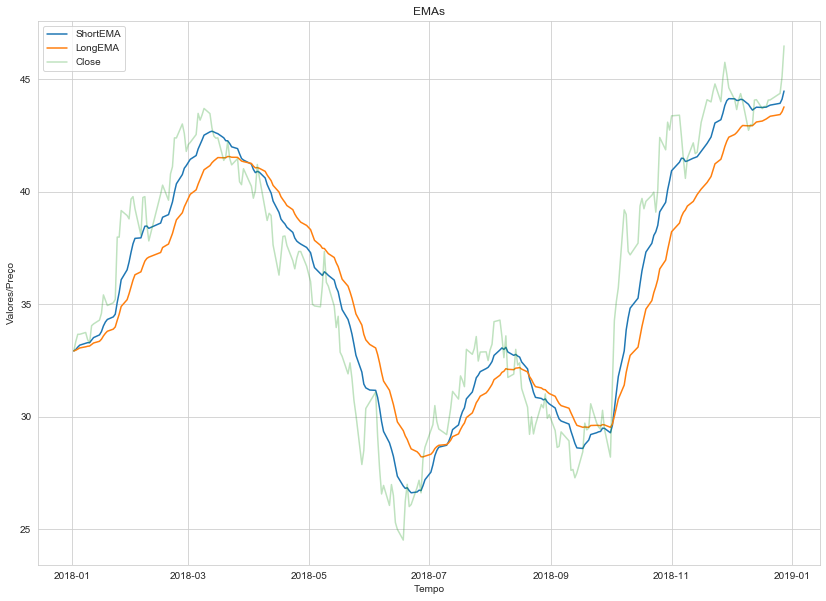

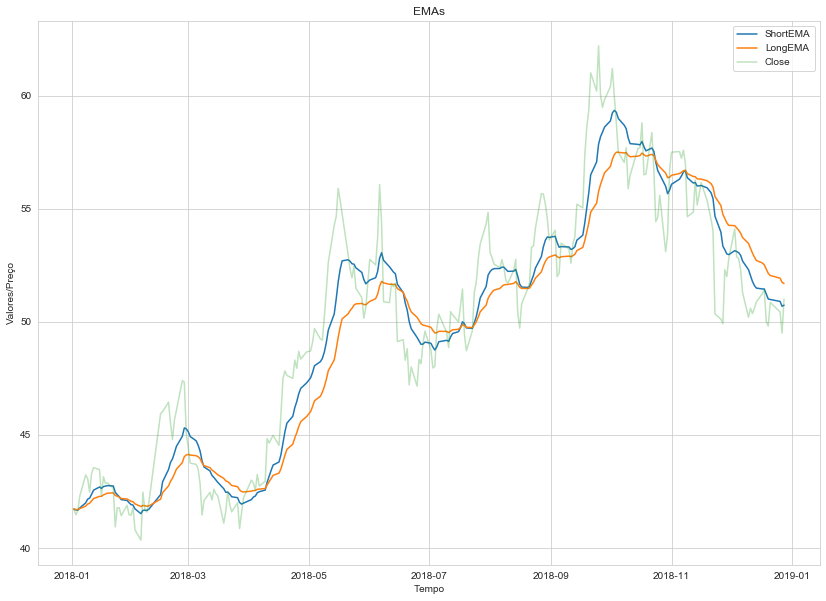

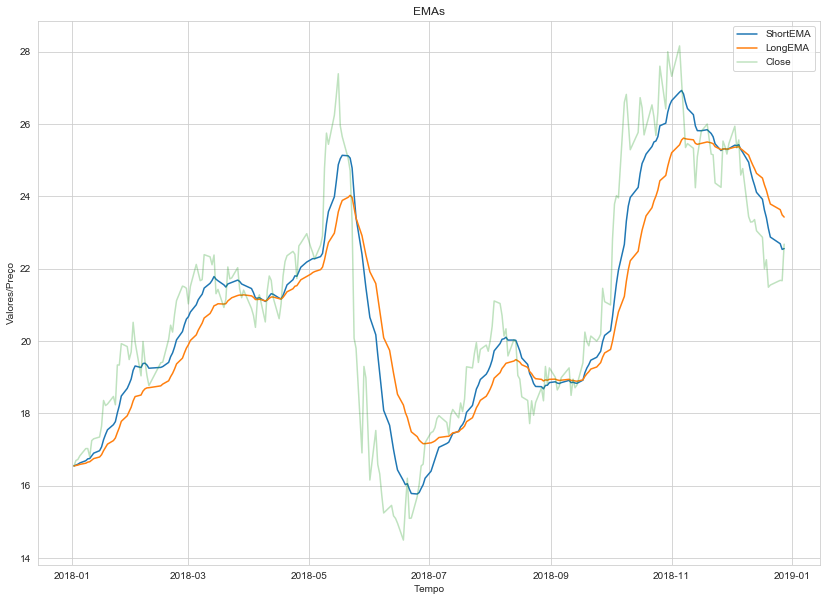

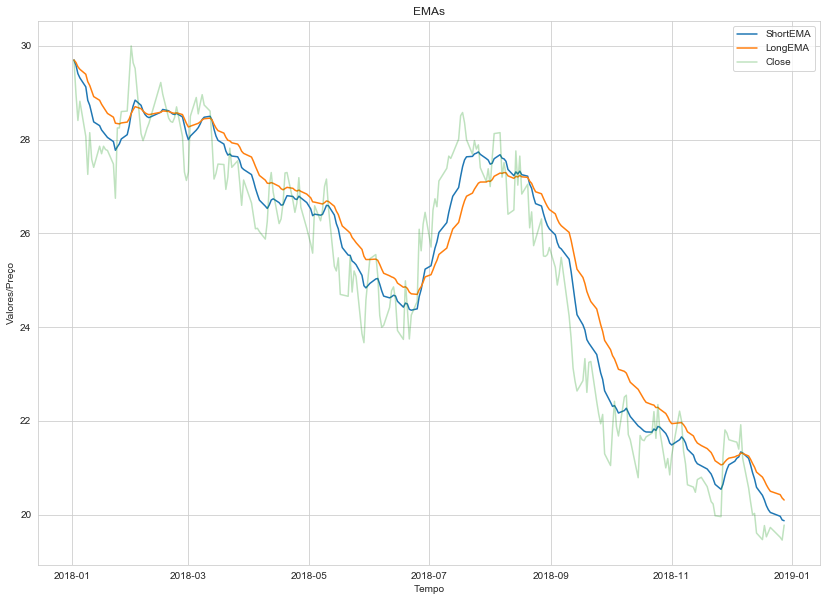

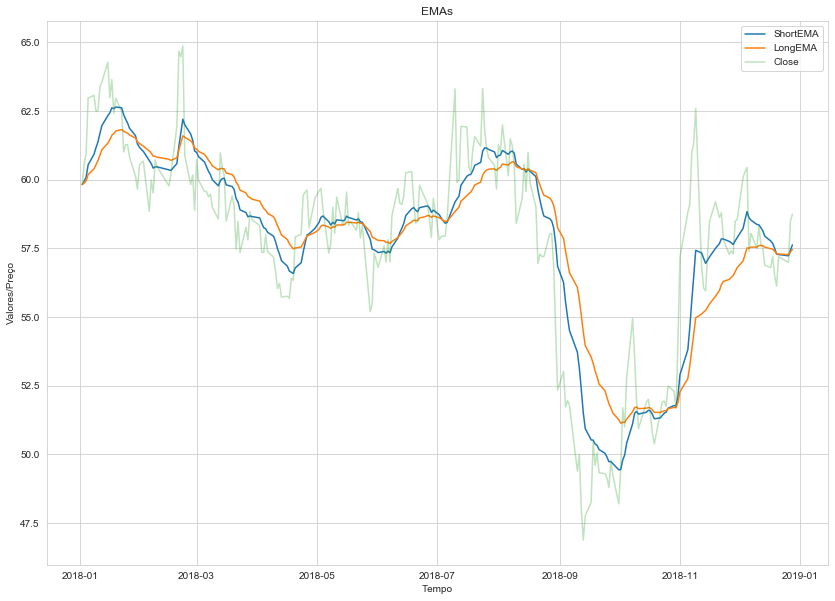

In [200]:
plot_emas(historicStock)

In [201]:
def plot_macd_signal(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14,10))
        if inflation == False:
            ax = stockScaled["MACD"].plot()
            ax = stockScaled["Signal"].plot()
            stockScaled["Close"].plot(alpha=0.3)
        else:
            ax = stockScaled["InflationMACD"].plot()
            ax = stockScaled["InflationSignal"].plot()
            stockScaled["InflationClose"].plot(alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.title("MACD e Signal")
        plt.show()

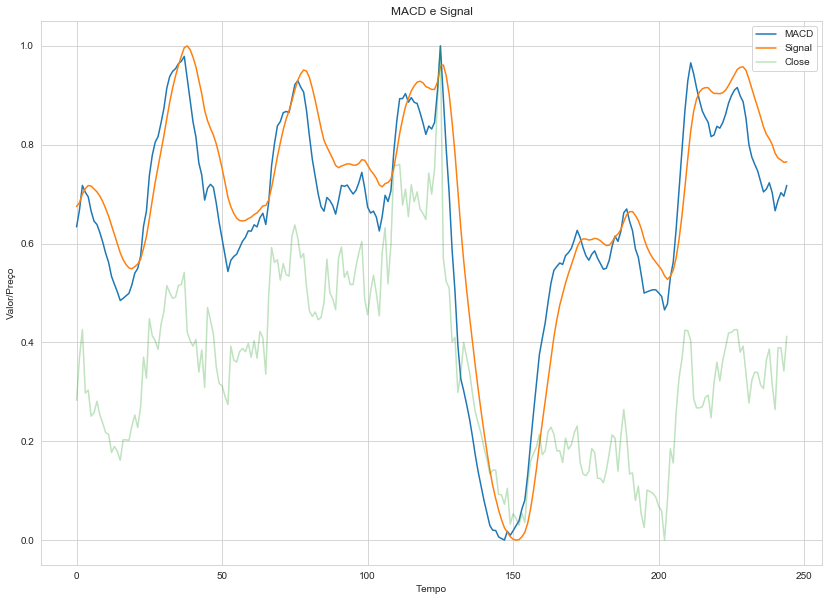

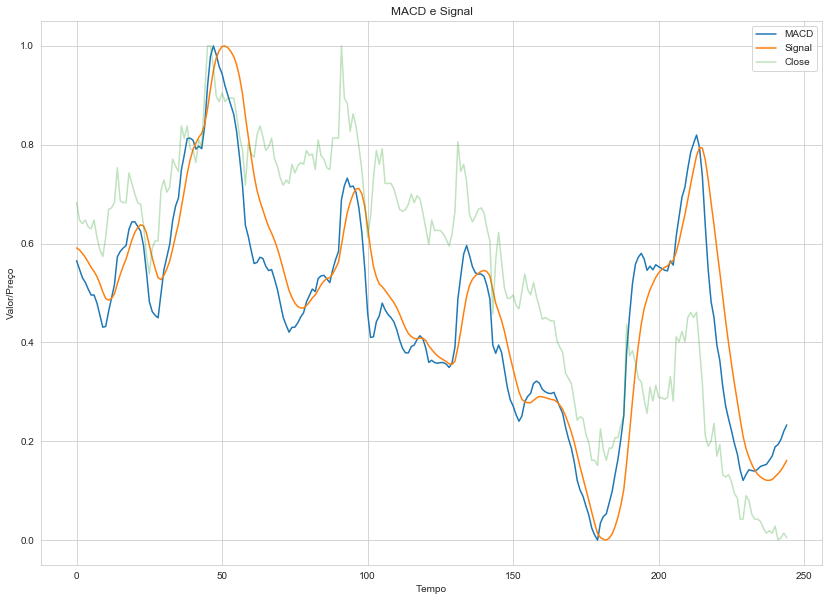

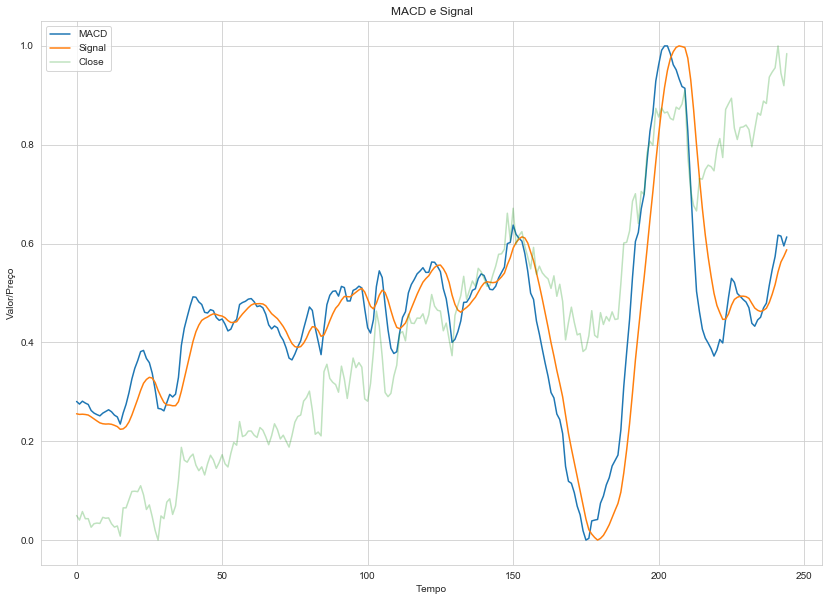

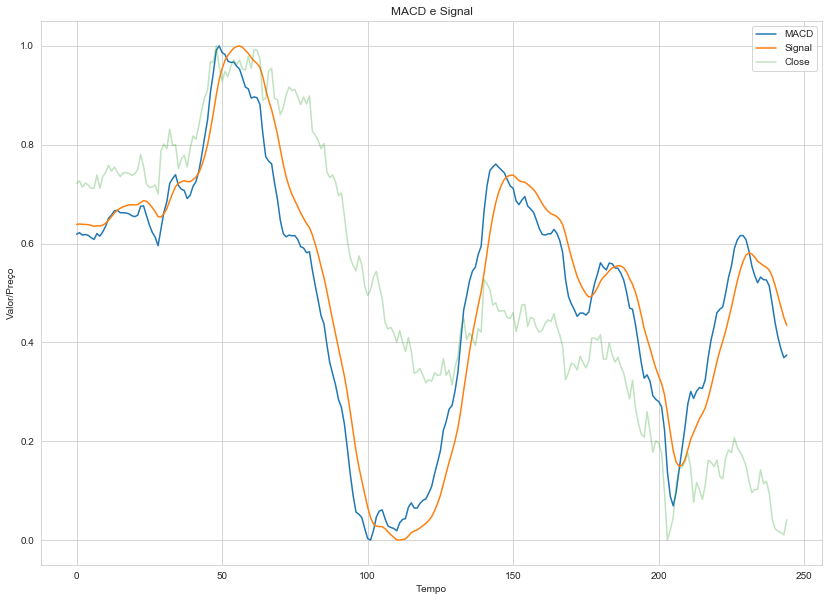

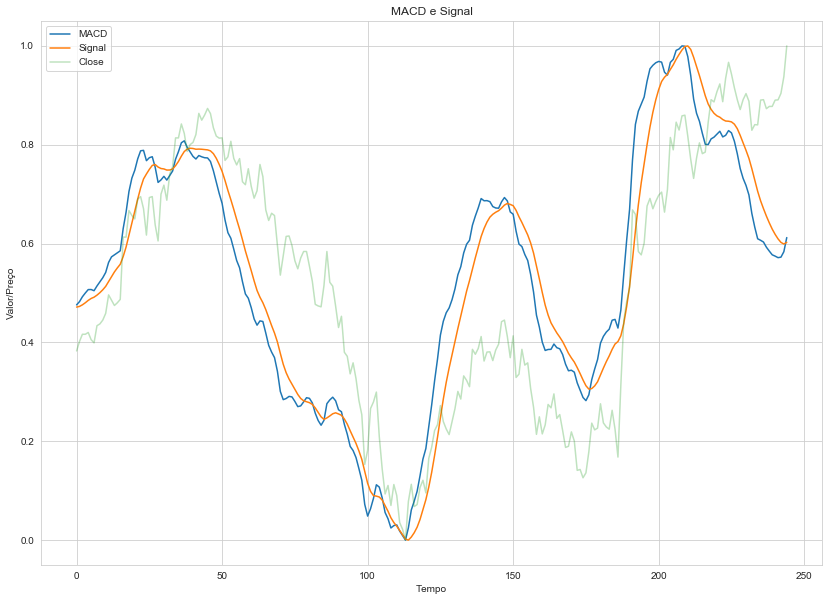

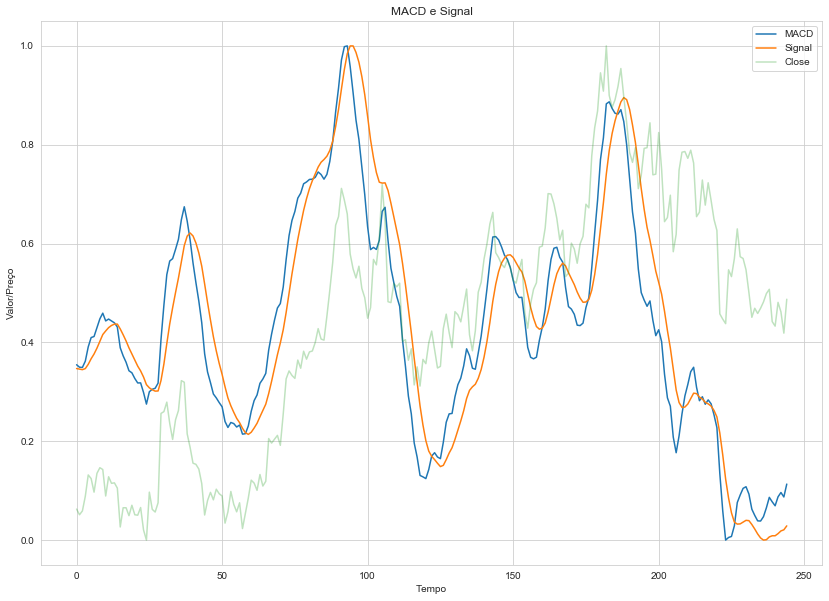

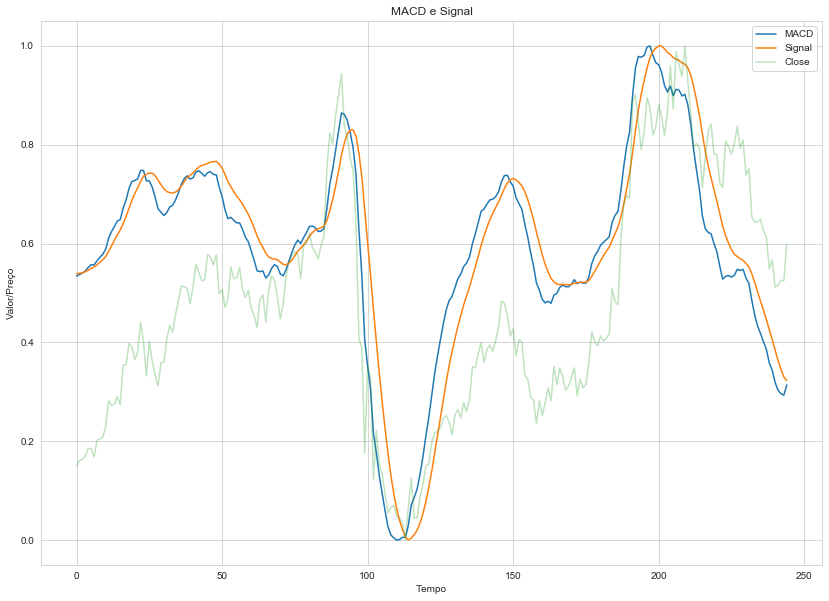

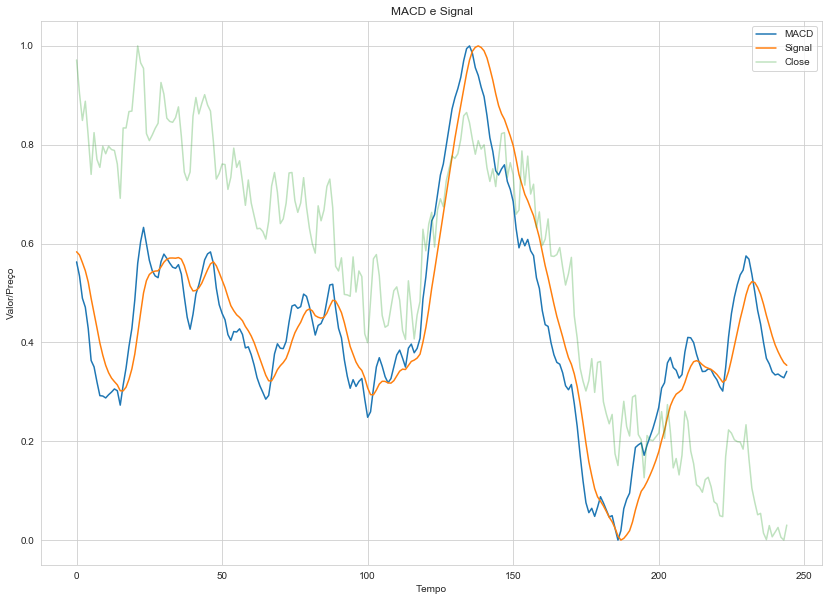

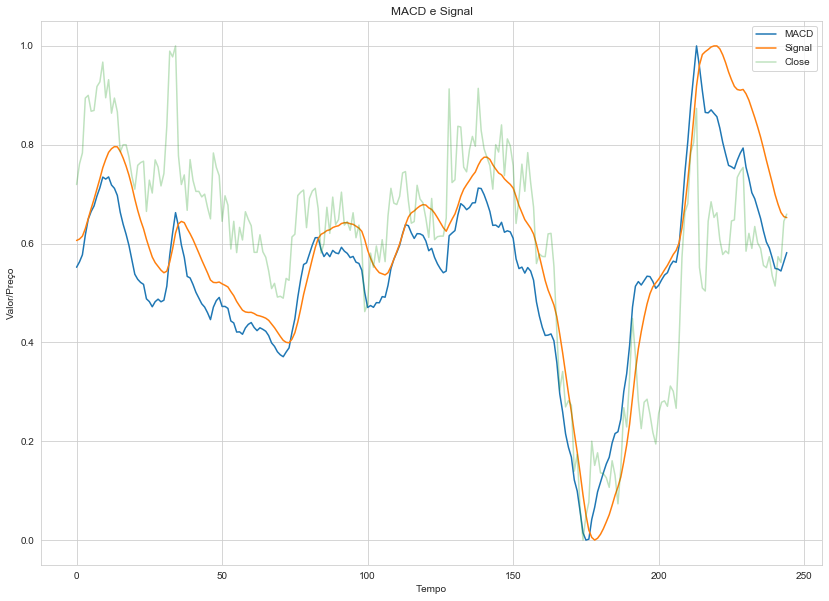

In [202]:
plot_macd_signal(historicStock)

In [203]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]
        
        plt.figure(figsize = (14,10))
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Preço')
        plt.title("Bandas de Bollinger")
        plt.show()

In [204]:
def calculate_bollinger_bands_stock(stock, inflation=False):
    if(inflation == False):
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
    else:
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]

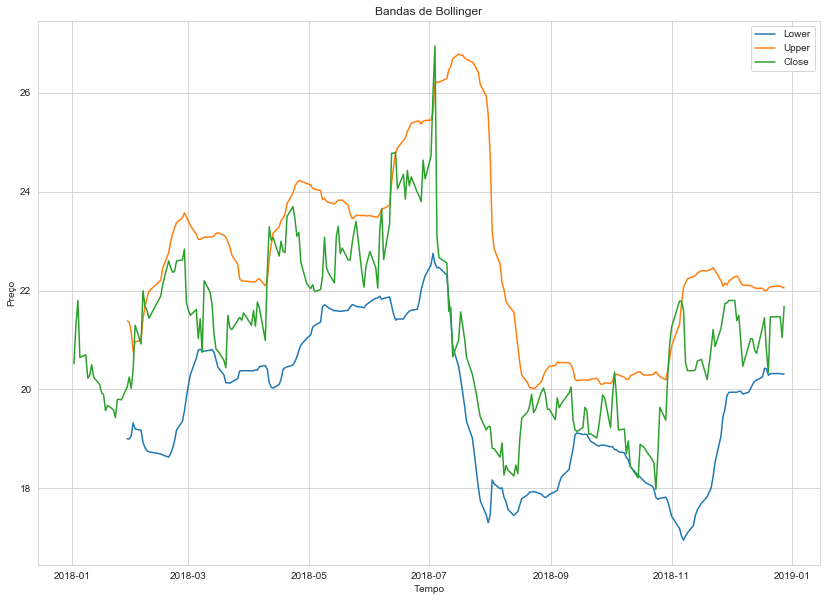

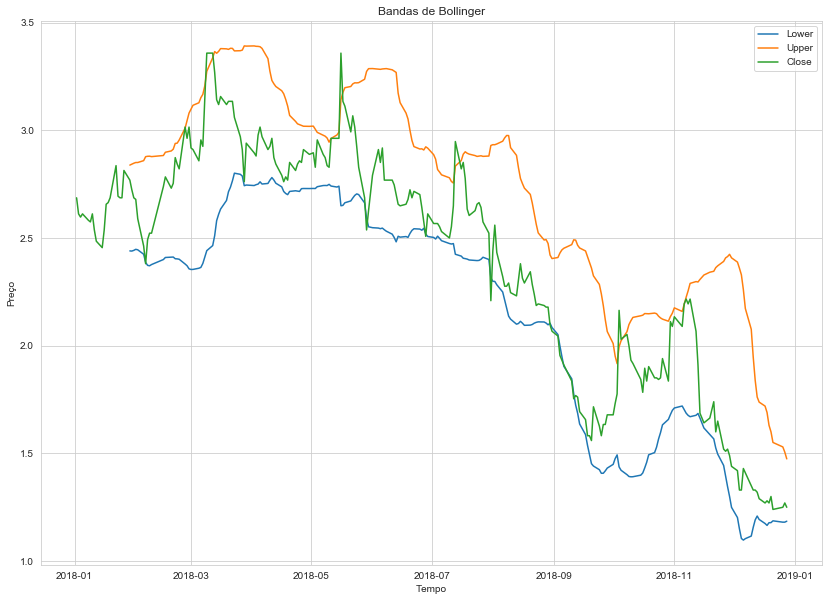

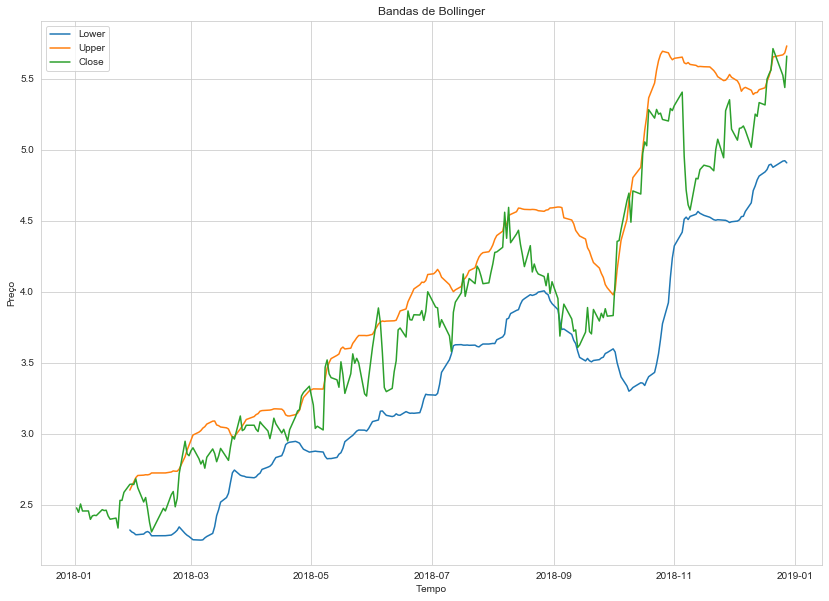

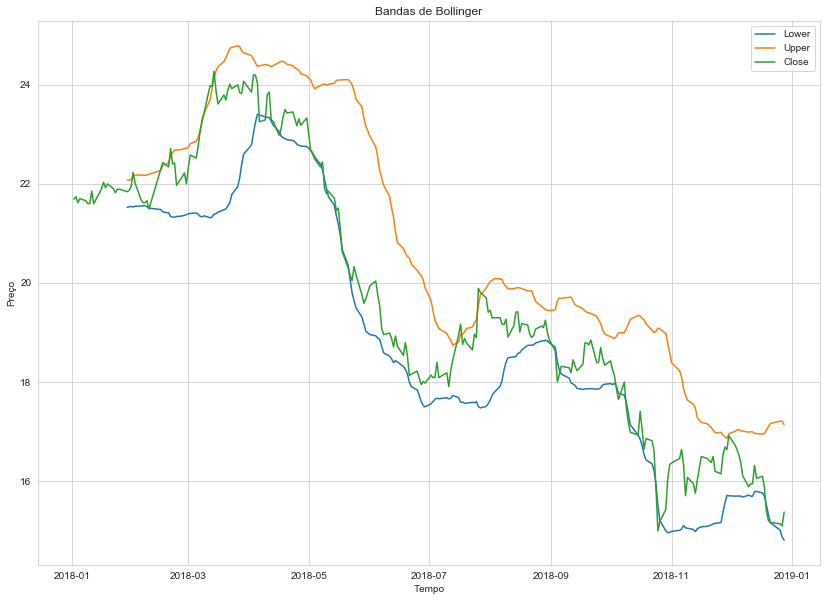

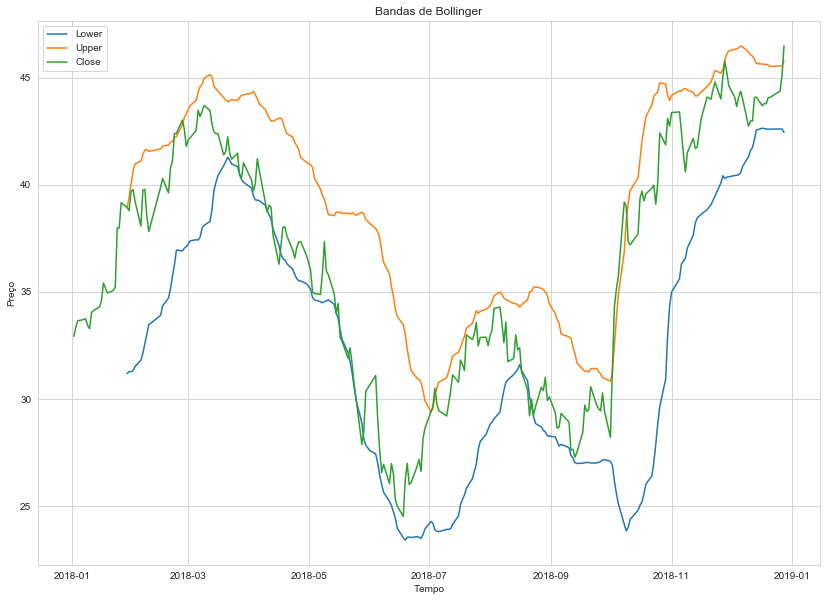

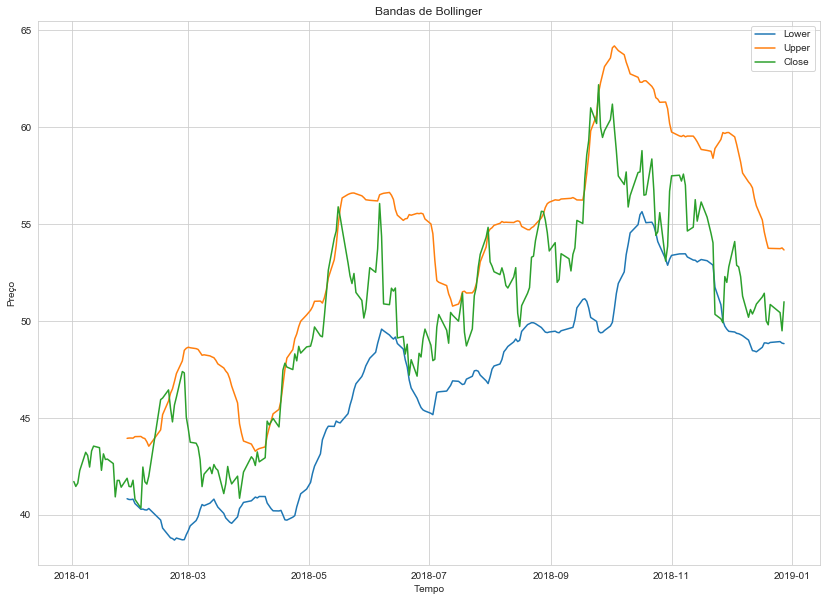

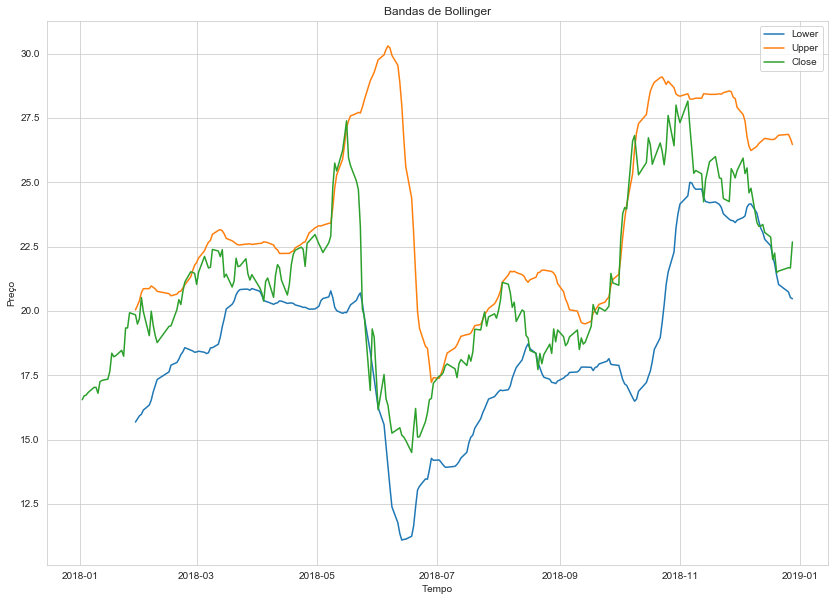

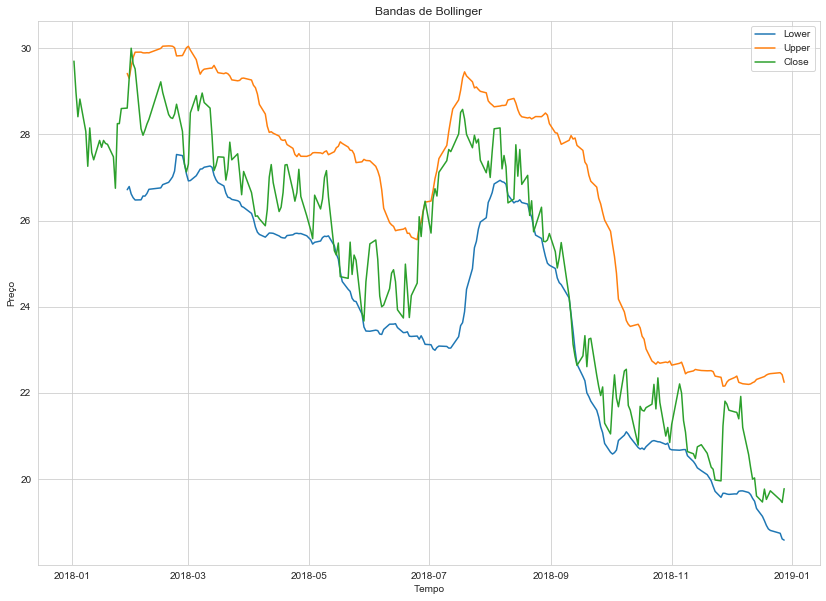

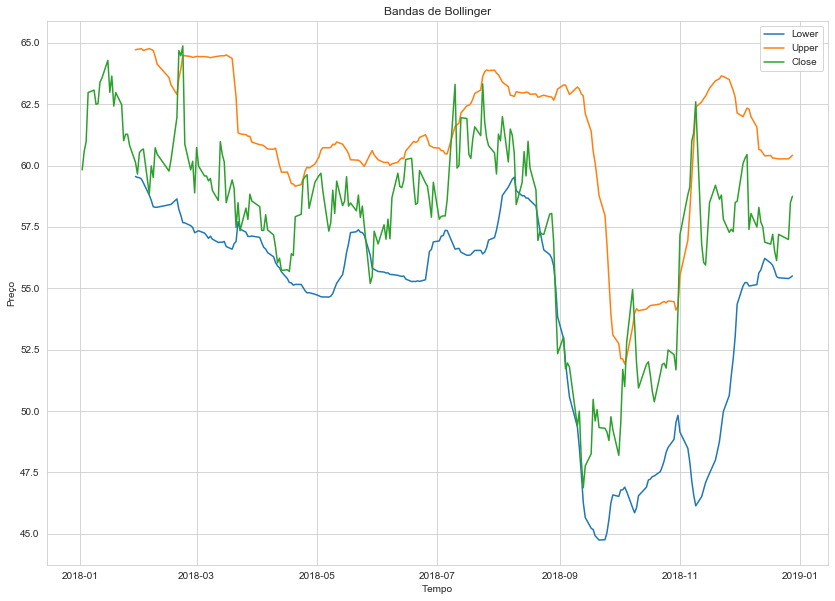

In [205]:
calculate_bollinger_bands()

In [206]:
def upOrDown():
    for stock in historicStock:
        stock["UpDown"] = stock["Close"].diff();
        stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [207]:
def upOrDownNpArray(array):
    difference = np.diff(array)
    diffReturn = []
    for i in difference:
        if i >= 0:
            diffReturn.append(1)
        else:
            diffReturn.append(0)
    return np.array(diffReturn)

In [208]:
def upOrDownStock(stock):
    stock["UpDown"] = stock["Close"].diff();
    stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [209]:
upOrDown()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [210]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [211]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [212]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [213]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor/Preço')
    plt.legend()
    plt.show()

In [214]:
def plot_rsi_close_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["RSI"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationRSI"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.7, color = 'red')
        ax.axhline(y = 0.3, color = 'lime')
        plt.title('Relação RSI e Close')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço normalizado')
        plt.legend()
        plt.show()

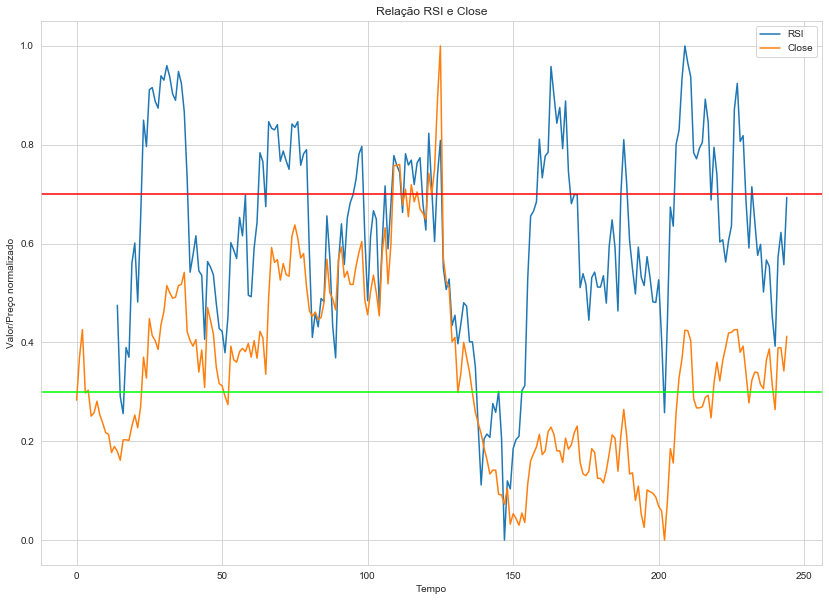

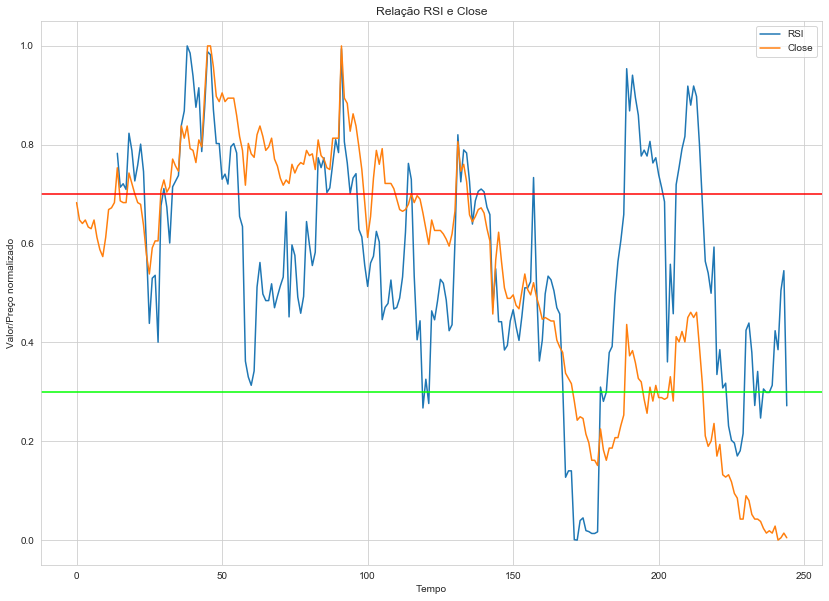

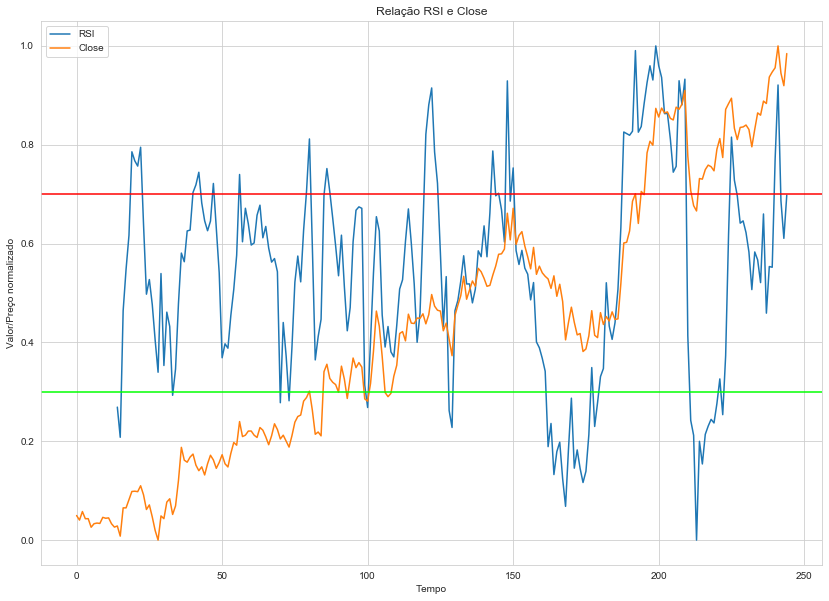

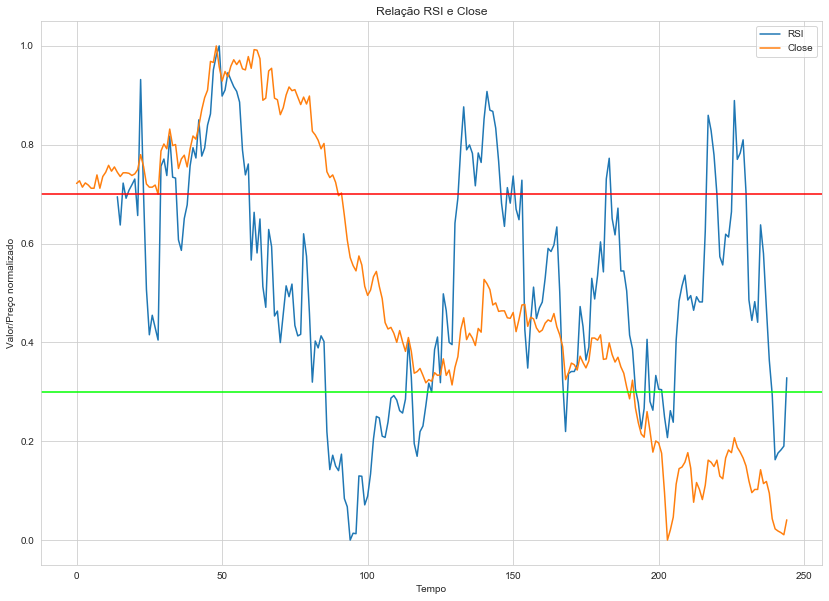

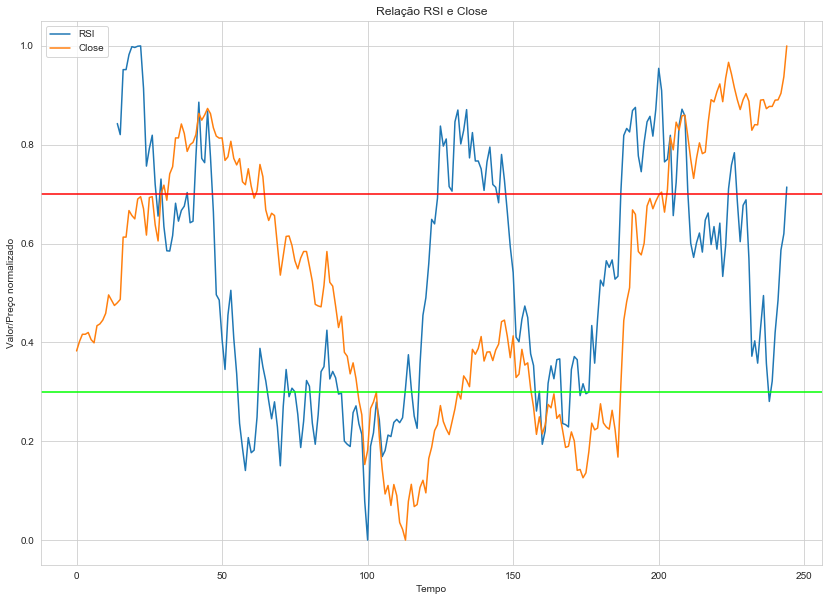

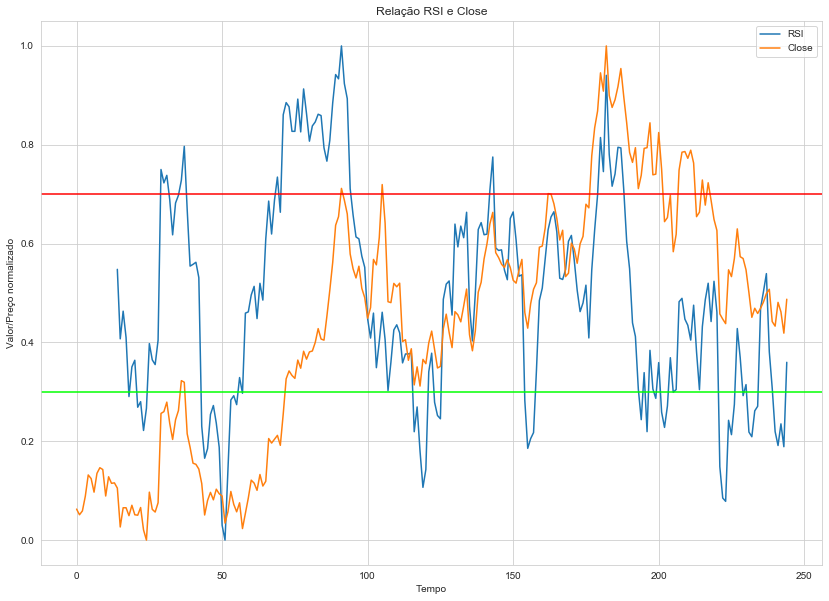

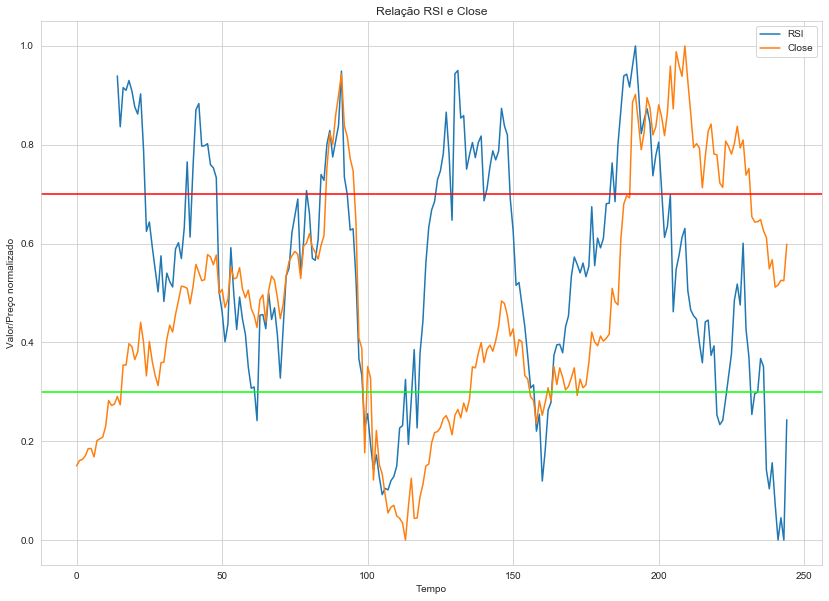

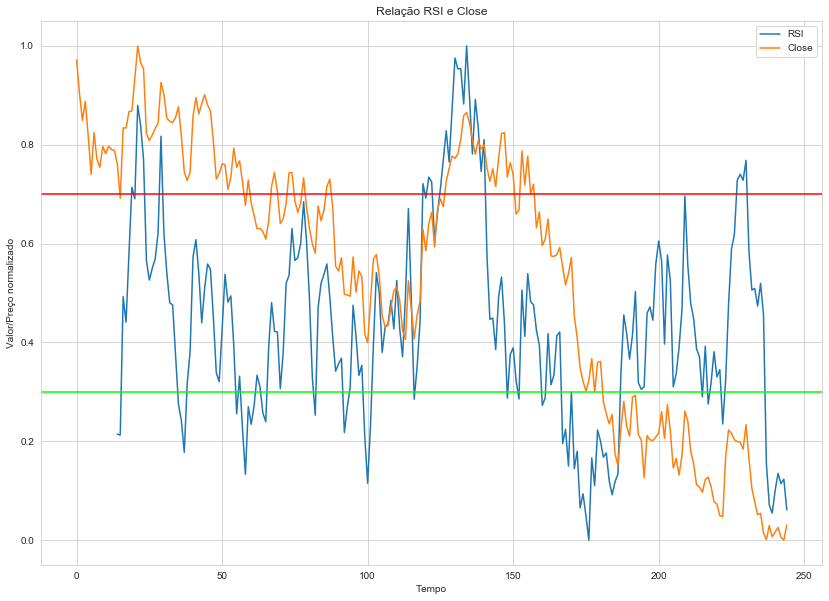

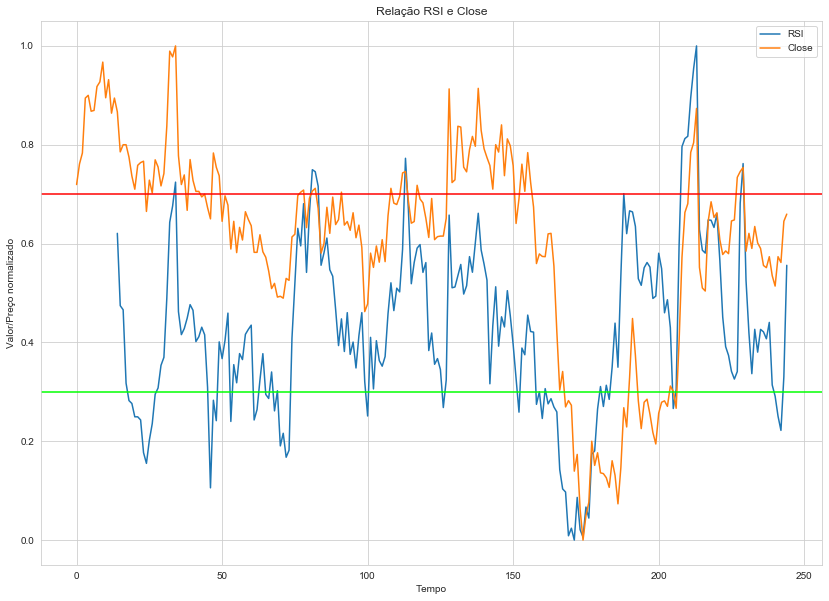

In [215]:
plot_rsi_close_all_stocks(historicStock)

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [216]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [217]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [218]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [219]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [220]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [221]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [222]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [223]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (14, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

In [224]:
def plot_stochastic_oscillator_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["StochasticOscillator"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationStochasticOscillator"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.2, color = 'red')
        ax.axhline(y = 0.8, color = 'lime')
        plt.title('Oscilador estocástico')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.legend()
        plt.show()

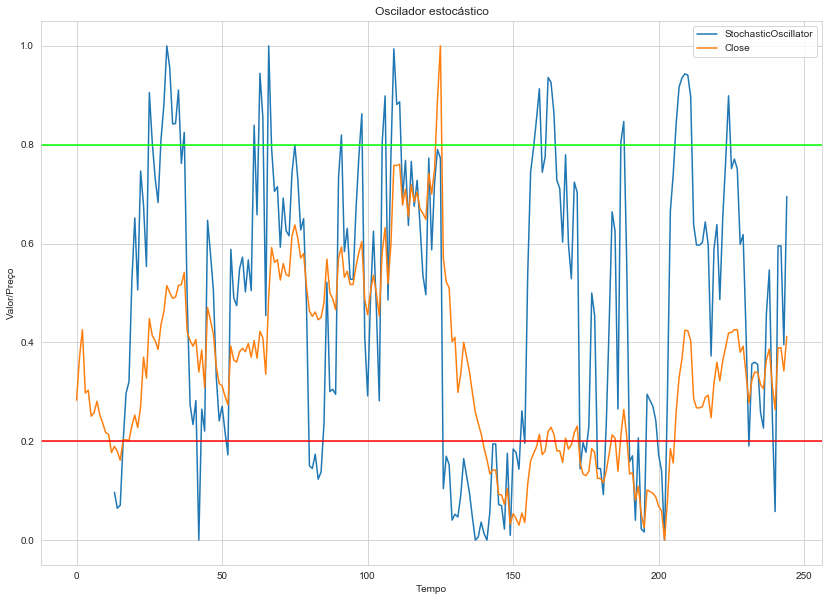

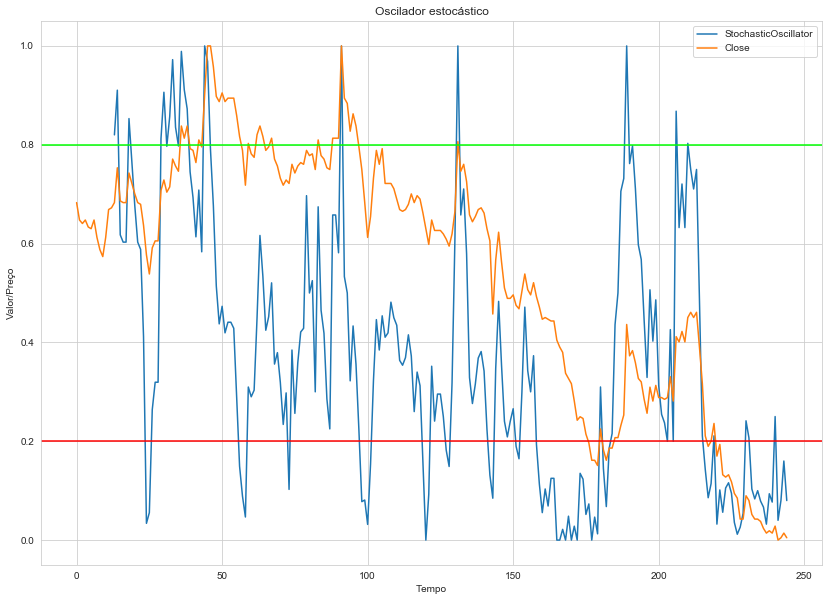

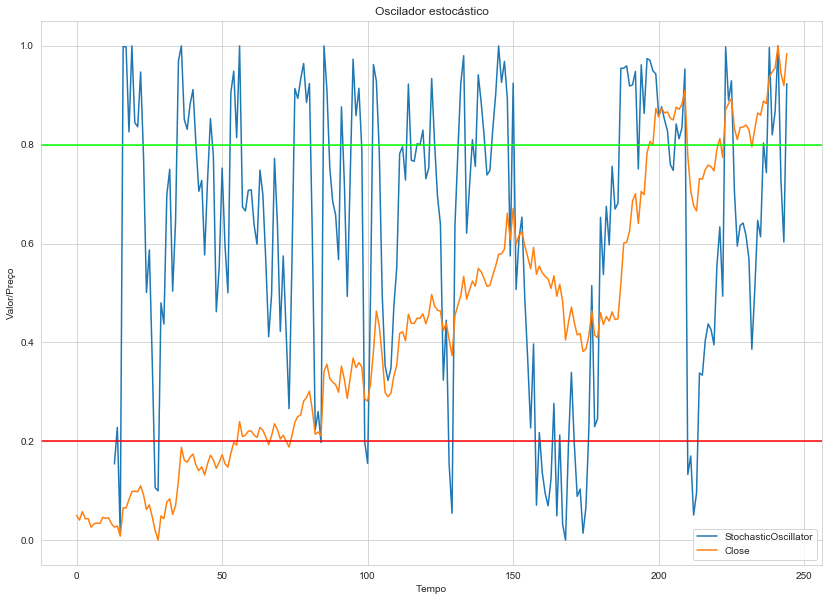

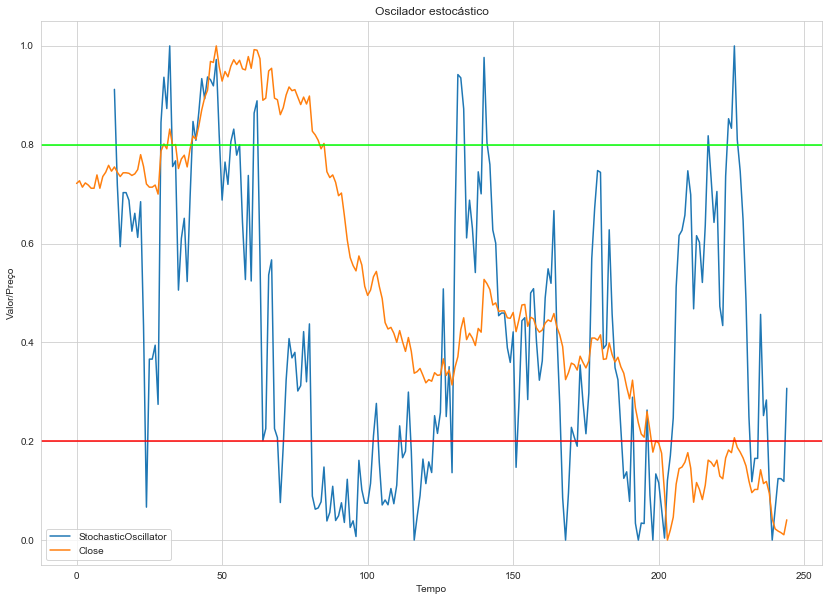

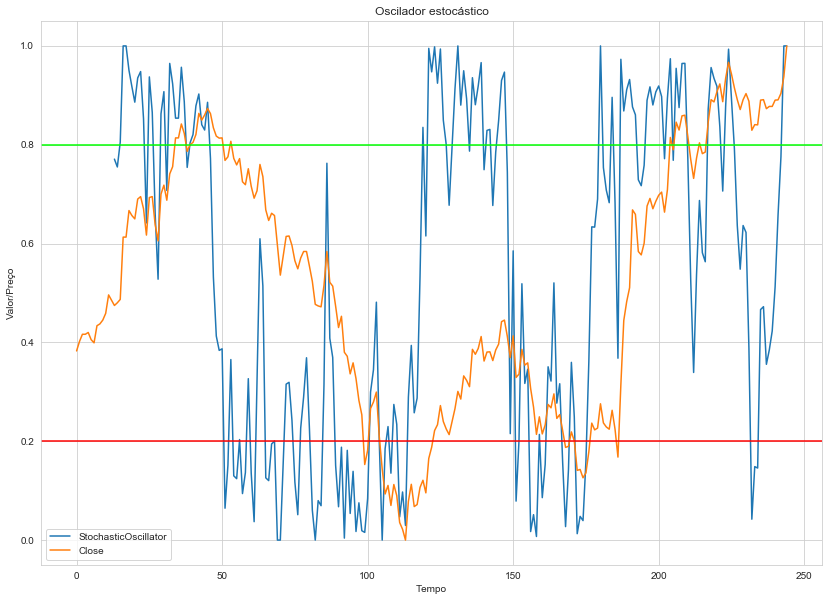

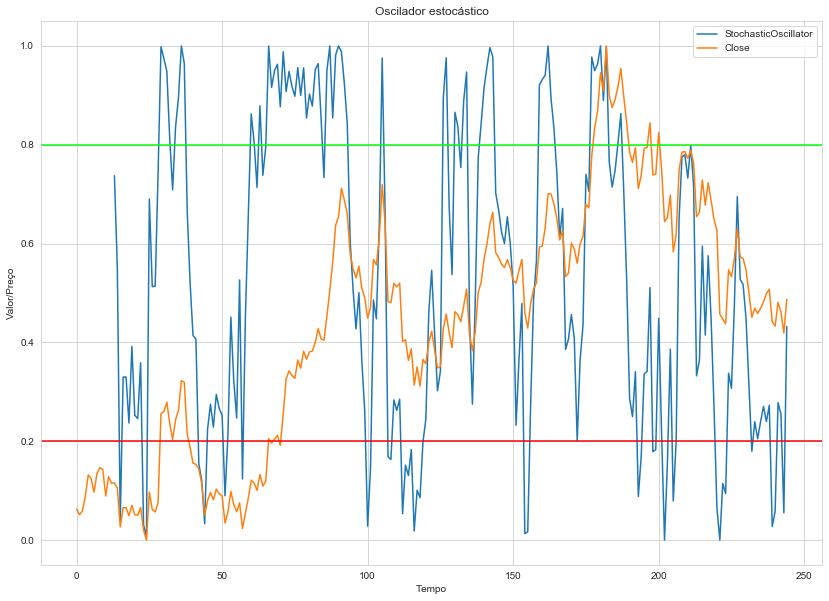

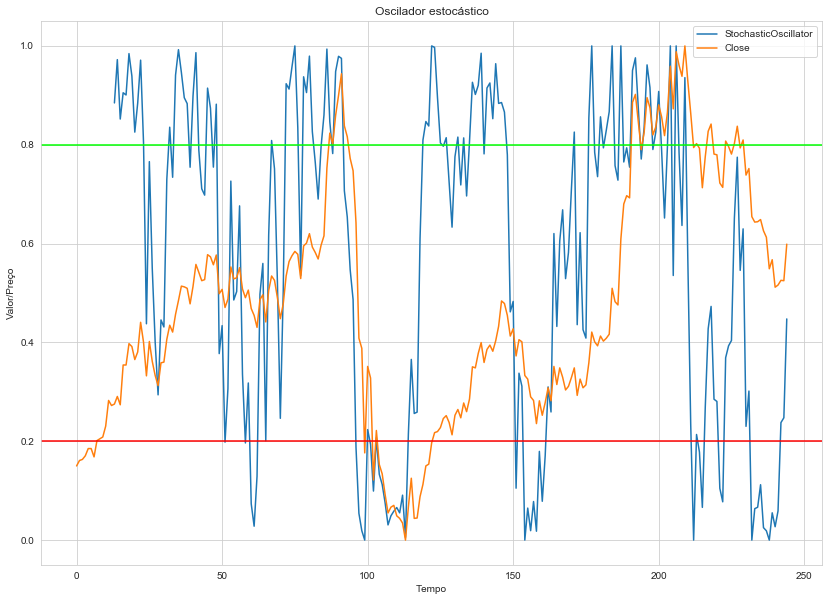

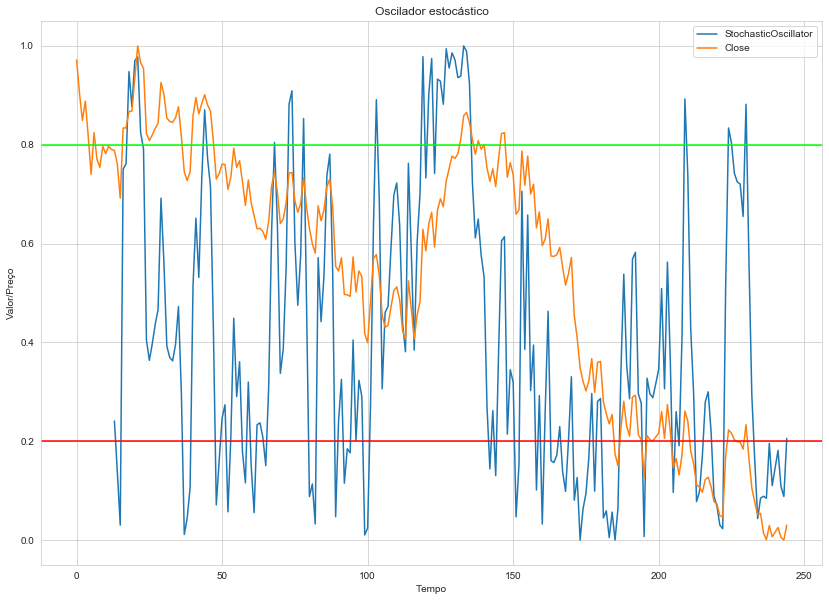

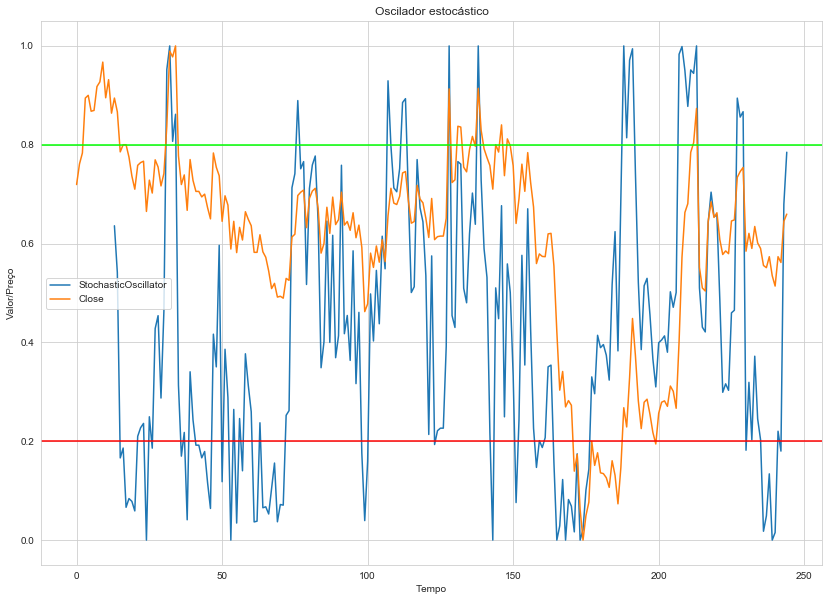

In [225]:
plot_stochastic_oscillator_all_stocks(historicStock)

<h2><b>Function to plot correlation matrix</b></h2>

In [226]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


    plt.figure(figsize = (10,10))
    sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
    plt.show()

In [227]:
def show_corr_matrix_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
        else:
            corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


        plt.figure(figsize = (10,10))
        sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
        plt.show()

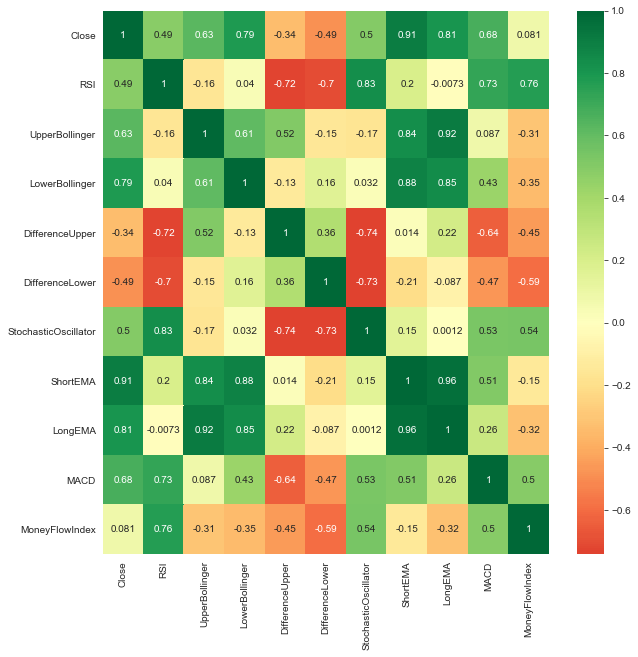

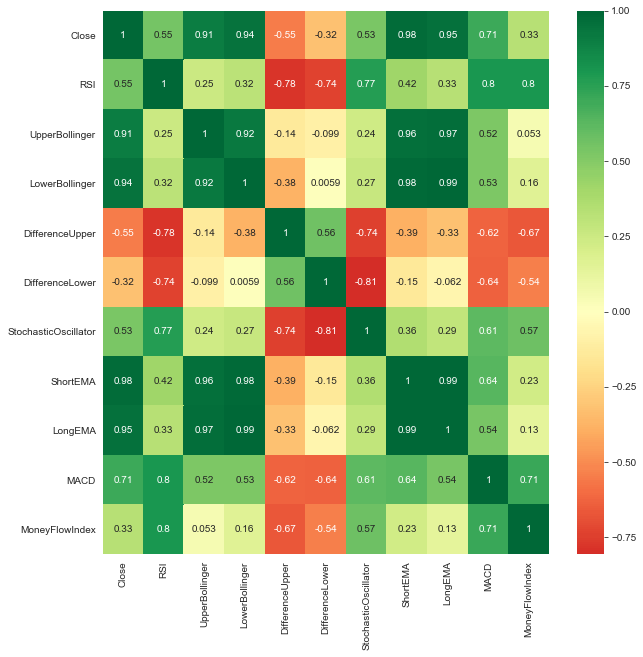

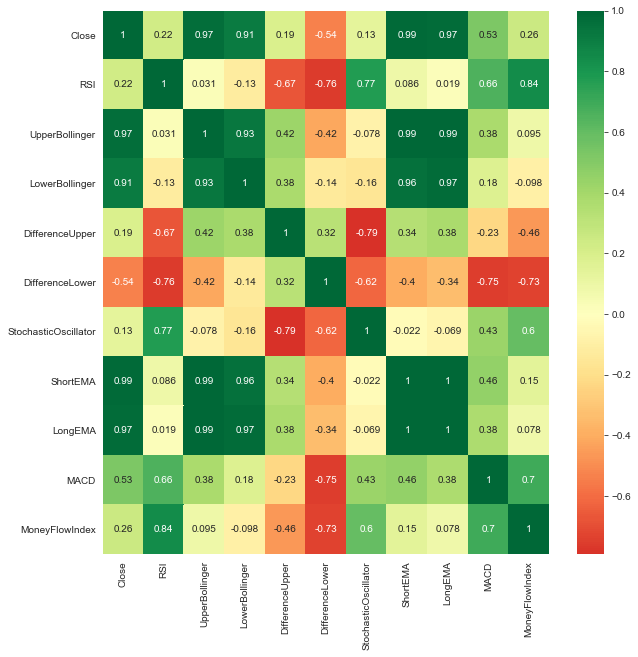

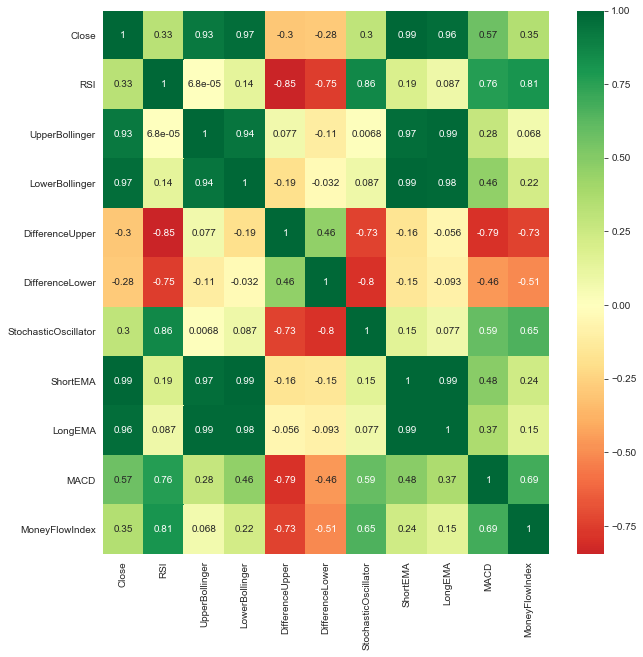

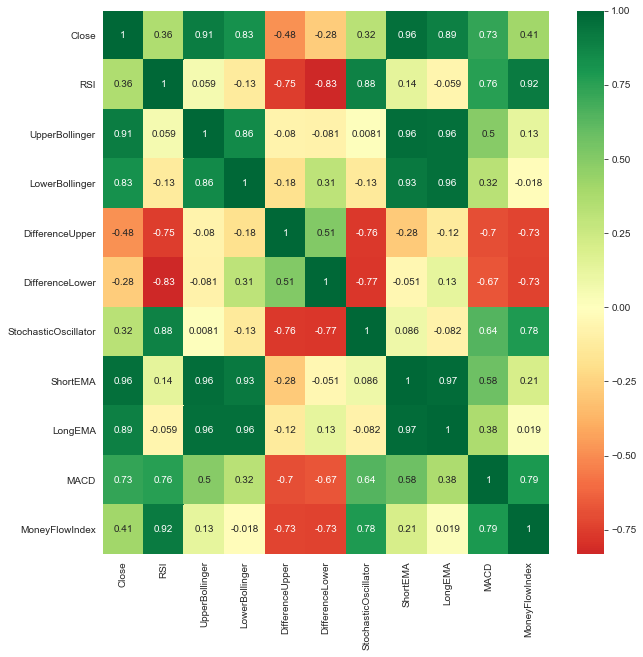

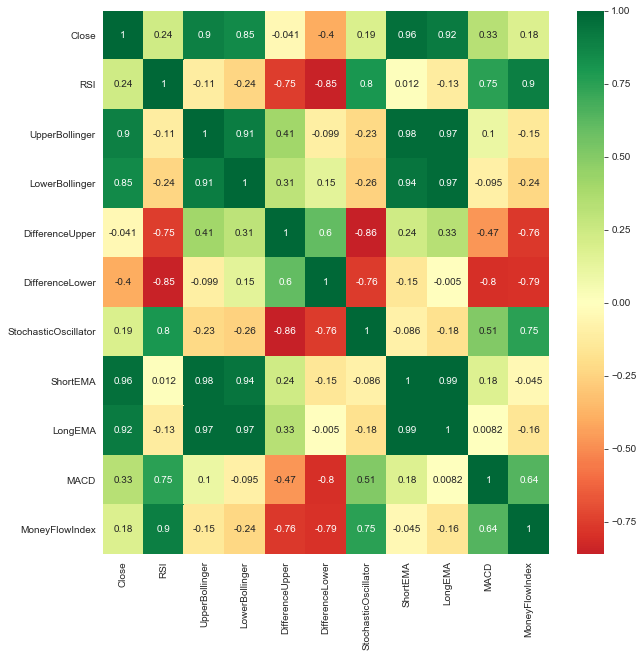

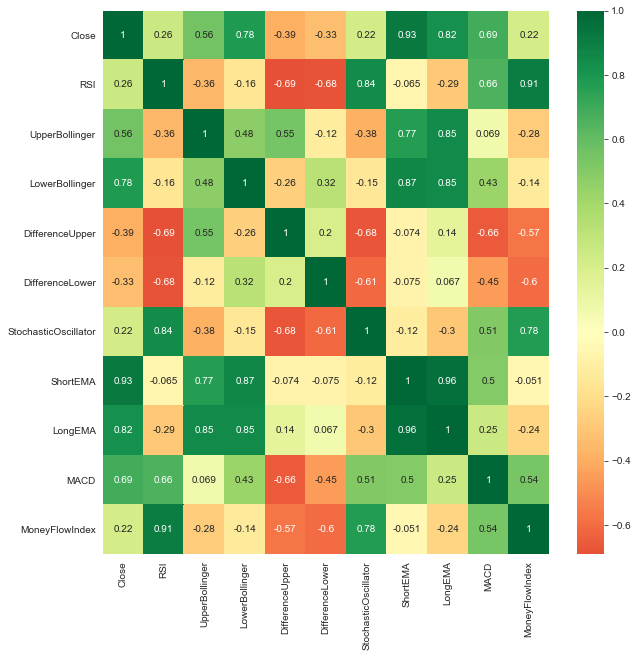

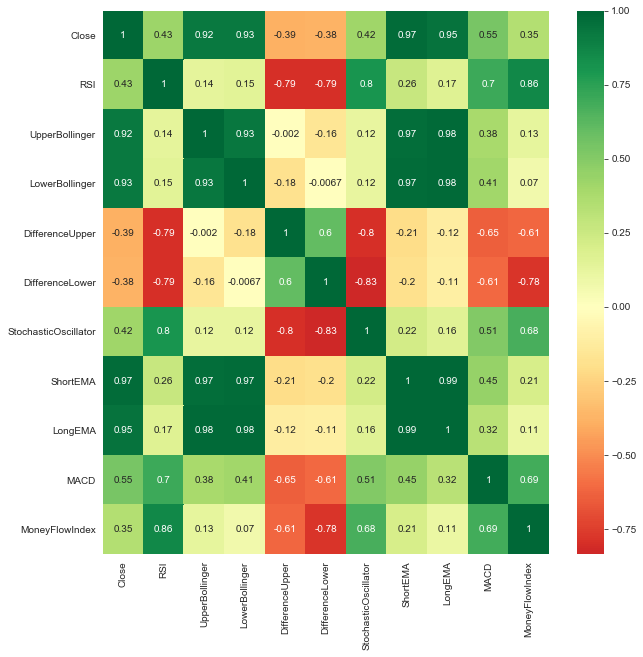

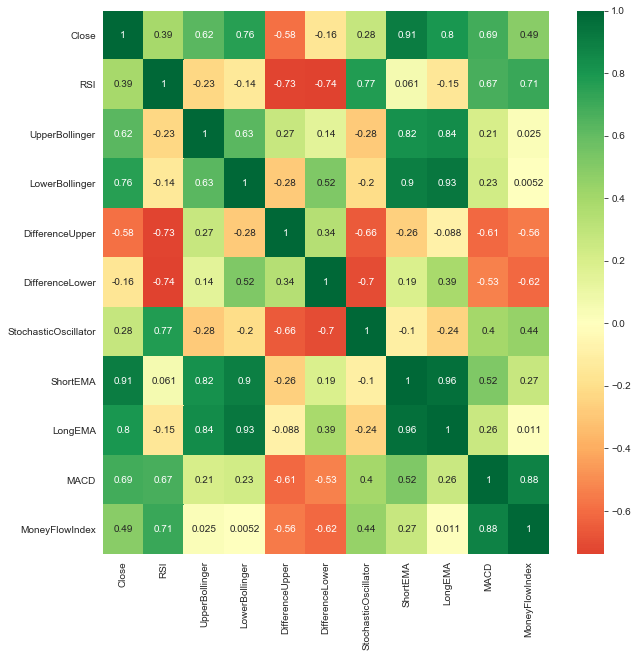

In [228]:
show_corr_matrix_all_stocks(historicStock)

<h2><b>Function to predict traditional SVM</b></h2>

In [229]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [230]:
svmRegressorClose = svm.SVR(kernel="rbf")
svmRegressorNu = svm.NuSVR(kernel="rbf")

In [231]:
def predict_svm_traditional_two_stocks(stock, stock2, inflation=False, feature='close'):
    if feature == 'close':
        print(stock2.shape)
        print(stock.shape)
        stock2 = stock2.rename(columns={"Close":"close","RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
        stock2X = stock2[["close","rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
        if inflation == False:
            stockX = stock[["Close","RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockX = pd.concat([stockX, stock2X], axis=1)
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [1, 10, 100], 'kernel': ('linear', 'rbf')}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [232]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-1]
        y = y[1:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [100], 'gamma': [0.0001]}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [233]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [234]:
def predict_plot_svm_all_stocks(stocks, inflation=False, feature='close'):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)

        y_pred = y_pred[1:]
        y_test = y_test[:-1]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'gamma': 0.0001}
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0
 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0]
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0]


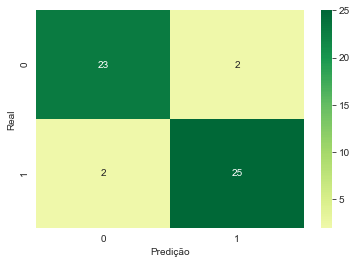

F1 score:  0.9259259259259259
Precision score:  0.9259259259259259
Accuracy score:  0.9230769230769231
MAE score:  0.10544313855107665
MSE value:  0.021537989695944816
RMSE value:  0.14675826959985872
MAPE value:  0.5309472140859812


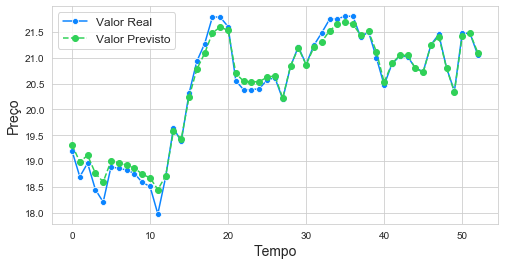

{'C': 100, 'gamma': 0.0001}
[0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1]
[0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1]


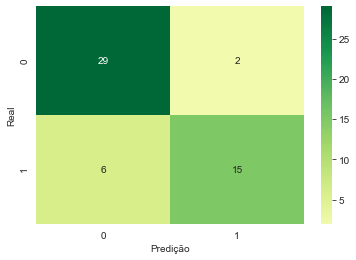

F1 score:  0.7894736842105262
Precision score:  0.8823529411764706
Accuracy score:  0.8461538461538461
MAE score:  0.20017630850538448
MSE value:  0.04258227475252589
RMSE value:  0.20635473038562963
MAPE value:  12.216704234245768


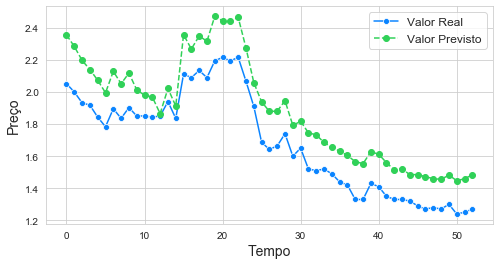

{'C': 100, 'gamma': 0.0001}
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0]
[1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0]


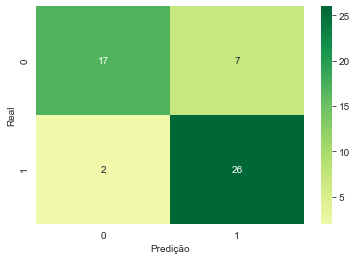

F1 score:  0.8524590163934426
Precision score:  0.7878787878787878
Accuracy score:  0.8269230769230769
MAE score:  0.18319820608106804
MSE value:  0.041334667578224
RMSE value:  0.2033092904375597
MAPE value:  3.620102701745114


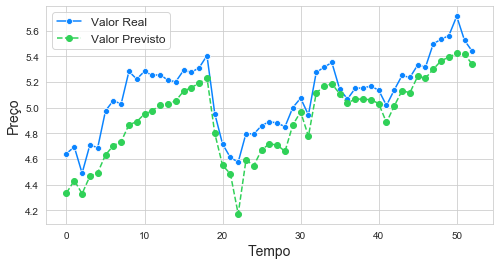

{'C': 100, 'gamma': 0.0001}
[0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0]


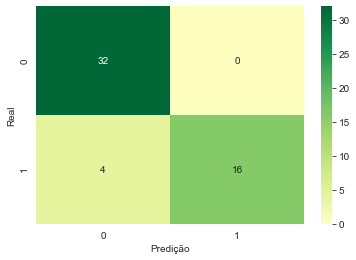

F1 score:  0.888888888888889
Precision score:  1.0
Accuracy score:  0.9230769230769231
MAE score:  0.24389326725520902
MSE value:  0.10254993960241099
RMSE value:  0.3202341949299153
MAPE value:  1.5197626434130758


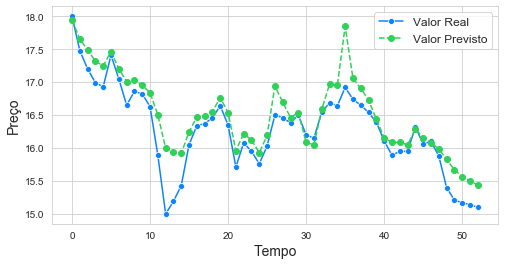

{'C': 100, 'gamma': 0.0001}
[1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1]
[0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]


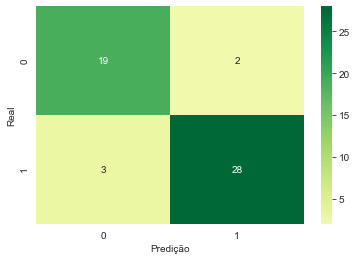

F1 score:  0.9180327868852459
Precision score:  0.9333333333333333
Accuracy score:  0.9038461538461539
MAE score:  0.30171318649808787
MSE value:  0.1442003103476186
RMSE value:  0.3797371595559468
MAPE value:  0.7272044618087268


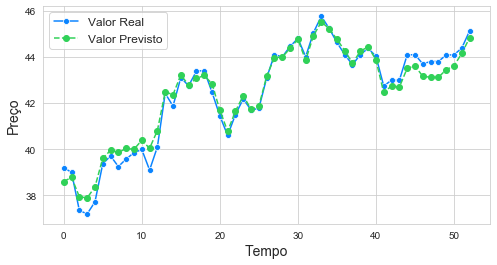

{'C': 100, 'gamma': 0.0001}
[1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0]
[1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]


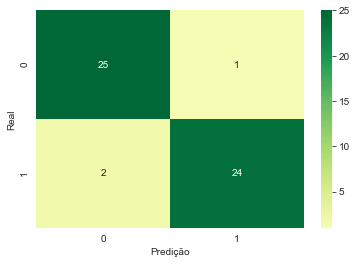

F1 score:  0.9411764705882353
Precision score:  0.96
Accuracy score:  0.9423076923076923
MAE score:  0.2982730885691053
MSE value:  0.1488045230790144
RMSE value:  0.3857518931632279
MAPE value:  0.5602626321925536


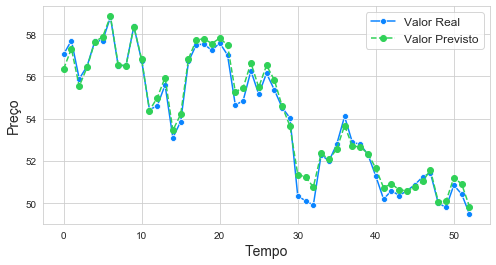

{'C': 100, 'gamma': 0.0001}
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0]
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0]


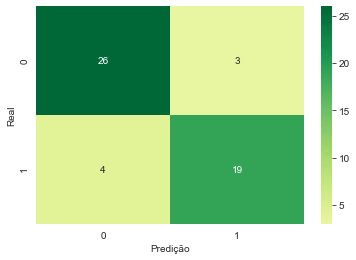

F1 score:  0.8444444444444444
Precision score:  0.8636363636363636
Accuracy score:  0.8653846153846154
MAE score:  1.127869676908205
MSE value:  1.5669447498097564
RMSE value:  1.2517766373477963
MAPE value:  4.5812986317749615


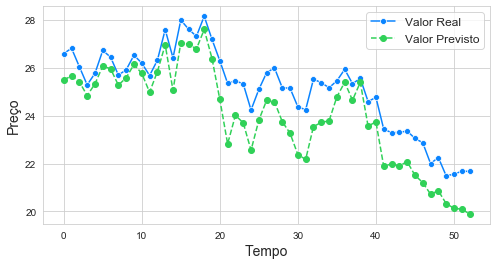

{'C': 100, 'gamma': 0.0001}
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]


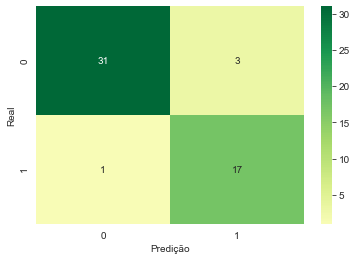

F1 score:  0.8947368421052632
Precision score:  0.85
Accuracy score:  0.9230769230769231
MAE score:  0.2738964752849878
MSE value:  0.19445551237889686
RMSE value:  0.44097110152355434
MAPE value:  1.286609128150627


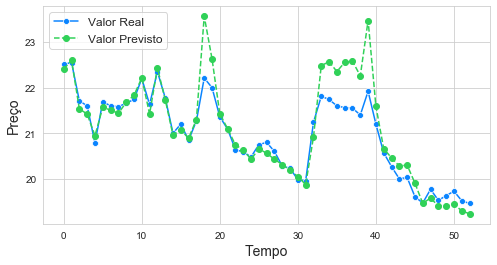

{'C': 100, 'gamma': 0.0001}
[0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1]
[0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1]


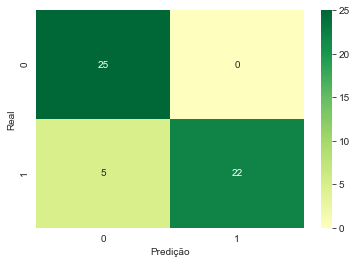

F1 score:  0.8979591836734693
Precision score:  1.0
Accuracy score:  0.9038461538461539
MAE score:  0.7526184063824924
MSE value:  1.133120625362568
RMSE value:  1.0644813879831663
MAPE value:  1.3361844249345758


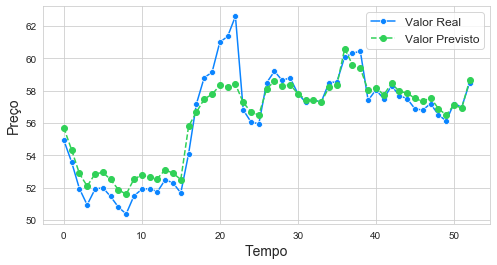

In [235]:
predict_plot_svm_all_stocks(historicStock)

<h2><b>Function to predict Nu SVM</b></h2>

In [236]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-1]
    y = y[1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'C': [100], 'nu': [0.5]}
    
    gssvm = GridSearchCV(svmRegressorNu, parameters)
    gssvm.fit(X_train, y_train)
    
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)

#     print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [237]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Nu SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [238]:
def predict_plot_svm_nu_all_stocks(stocks, inflation=False):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_nu(stock)

        y_pred = y_pred[1:]
        y_test = y_test[:-1]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'nu': 0.5}
[1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0
 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0]
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0]


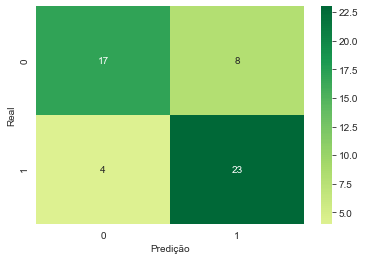

F1 score:  0.7931034482758621
Precision score:  0.7419354838709677
Accuracy score:  0.7692307692307693
MAE score:  0.1684363587848952
MSE value:  0.0633994764715492
RMSE value:  0.2517925266395911
MAPE value:  0.8592728988982155


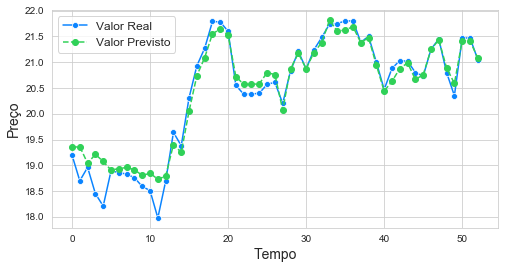

{'C': 100, 'nu': 0.5}
[0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0]
[0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1]


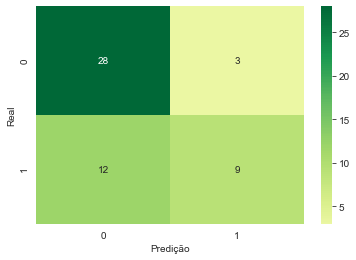

F1 score:  0.5454545454545454
Precision score:  0.75
Accuracy score:  0.7115384615384616
MAE score:  0.1125060591841576
MSE value:  0.017701582246157616
RMSE value:  0.13304729326881332
MAPE value:  6.512072191777758


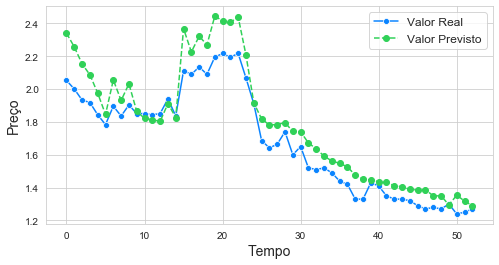

{'C': 100, 'nu': 0.5}
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1
 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0]
[1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0]


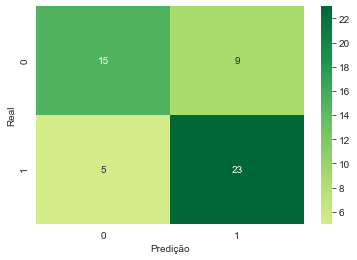

F1 score:  0.7666666666666666
Precision score:  0.71875
Accuracy score:  0.7307692307692307
MAE score:  0.15958595504936182
MSE value:  0.03833960310028951
RMSE value:  0.19580501296006064
MAPE value:  3.1800972589098935


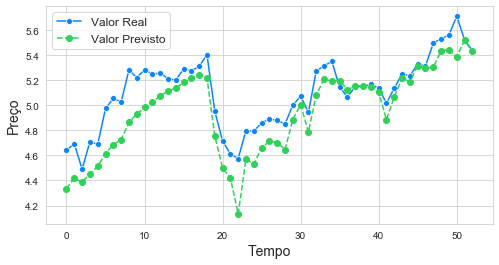

{'C': 100, 'nu': 0.5}
[0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0]
[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0]


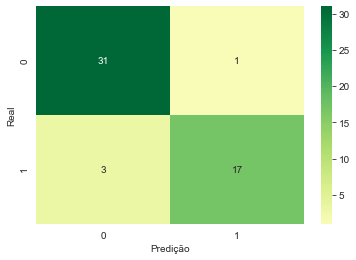

F1 score:  0.8947368421052632
Precision score:  0.9444444444444444
Accuracy score:  0.9230769230769231
MAE score:  0.2664139156190858
MSE value:  0.12262886976550169
RMSE value:  0.35018405127232977
MAPE value:  1.674302236592537


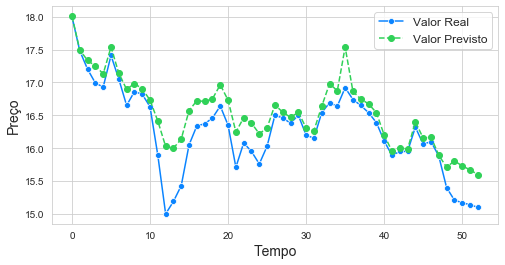

{'C': 100, 'nu': 0.5}
[0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1]
[0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]


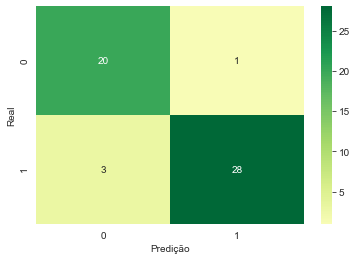

F1 score:  0.9333333333333333
Precision score:  0.9655172413793104
Accuracy score:  0.9230769230769231
MAE score:  0.38502063275072884
MSE value:  0.20591722310142233
RMSE value:  0.4537810299047574
MAPE value:  0.9042488036095043


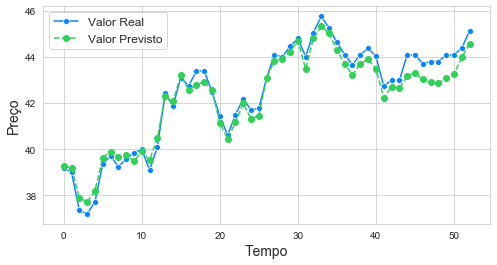

{'C': 100, 'nu': 0.5}
[1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0]
[1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]


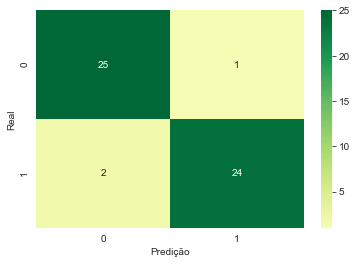

F1 score:  0.9411764705882353
Precision score:  0.96
Accuracy score:  0.9423076923076923
MAE score:  0.5043125647153284
MSE value:  0.377583948204757
RMSE value:  0.614478598654792
MAPE value:  0.9395995738779546


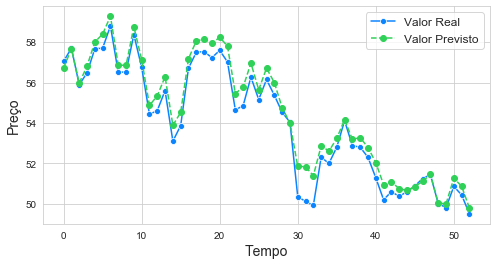

{'C': 100, 'nu': 0.5}
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0]
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0]


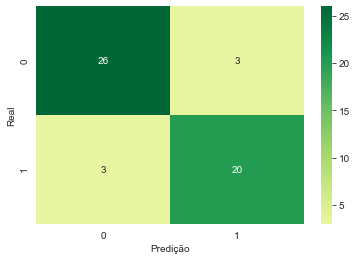

F1 score:  0.8695652173913043
Precision score:  0.8695652173913043
Accuracy score:  0.8846153846153846
MAE score:  1.127609926583013
MSE value:  1.8119643132370666
RMSE value:  1.3460922380123386
MAPE value:  4.622308215368537


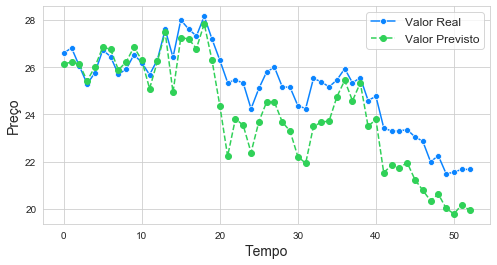

{'C': 100, 'nu': 0.5}
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]


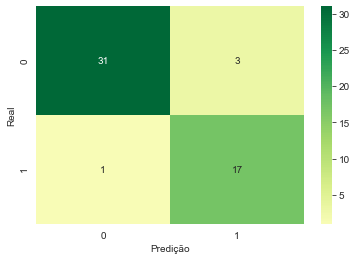

F1 score:  0.8947368421052632
Precision score:  0.85
Accuracy score:  0.9230769230769231
MAE score:  0.5333514381132216
MSE value:  0.346105258079483
RMSE value:  0.588307112042242
MAPE value:  2.5515965628381863


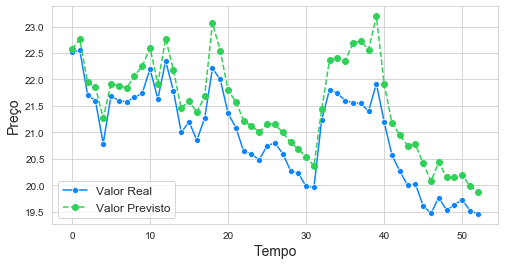

{'C': 100, 'nu': 0.5}
[0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1]
[0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1]


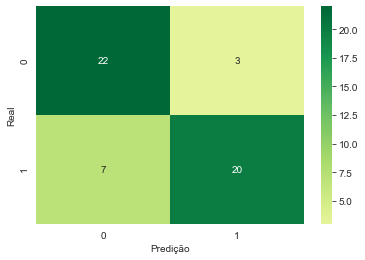

F1 score:  0.7999999999999999
Precision score:  0.8695652173913043
Accuracy score:  0.8076923076923077
MAE score:  1.0054287690531964
MSE value:  2.227888495614827
RMSE value:  1.4926113009135455
MAPE value:  1.7731273019639247


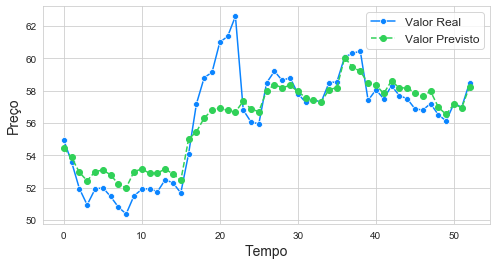

In [239]:
predict_plot_svm_nu_all_stocks(historicStock)

<h2><b>Scaling data for LSTM</b></h2>

In [240]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [241]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [242]:
# predict_LSTM(stockScaled[0])

<h2><b>Function to predict with Kernel Ridge Regression</b></h2>

In [243]:
clf = KernelRidge(alpha=1.0, kernel='rbf')

In [244]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'alpha': [1], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

    clf = KernelRidge(alpha=1.0)
    gssvm = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
    gssvm.fit(X_train, y_train)
        
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (6,4))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    sns.set_style("whitegrid")
    plt.figure(figsize = (8,4))
    sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [245]:
def predict_kernel_ridge_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["Close","RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-1]
        y = y[1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        parameters = {'alpha': [1], 'gamma': [1]}

        clf = KernelRidge(alpha=1.0)
        gssvm = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
        gssvm.fit(X_train, y_train)

        y_pred = gssvm.predict(X_test)

        print(gssvm.best_params_)

        y_pred = y_pred[1:]
        y_test = y_test[:-1]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))


        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'alpha': 1, 'gamma': 1}
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0
 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0]
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0]


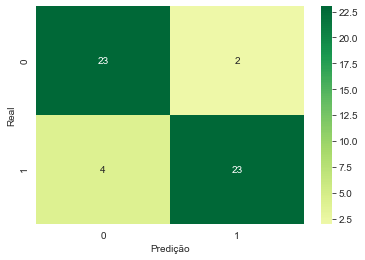

F1 score:  0.8846153846153846
Precision score:  0.92
Accuracy score:  0.8846153846153846
MAE score:  0.1486192761521004
MSE value:  0.04451703489603588
RMSE value:  0.21099060380982818
MAPE value:  0.7156067046784527


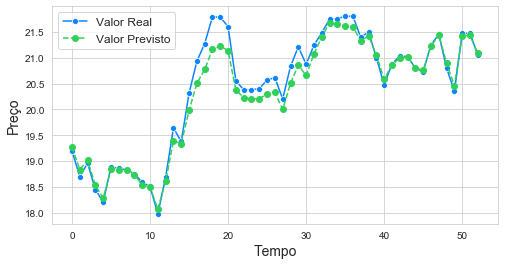

{'alpha': 1, 'gamma': 1}
[0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1]
[0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1]


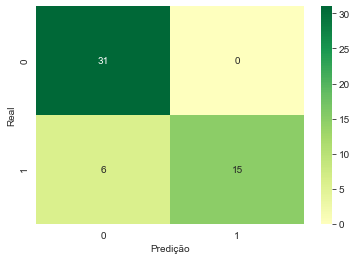

F1 score:  0.8333333333333333
Precision score:  1.0
Accuracy score:  0.8846153846153846
MAE score:  0.032580944655518244
MSE value:  0.0017285443294770856
RMSE value:  0.04157576613217231
MAPE value:  1.9014233556465956


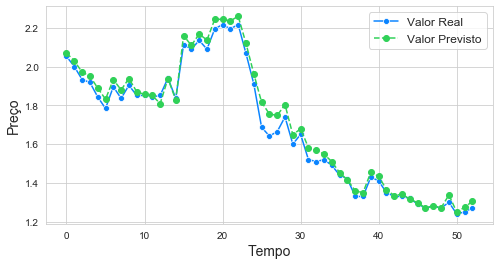

{'alpha': 1, 'gamma': 1}
[1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0]
[1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0]


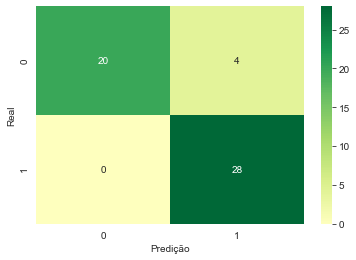

F1 score:  0.9333333333333333
Precision score:  0.875
Accuracy score:  0.9230769230769231
MAE score:  0.089013470295297
MSE value:  0.013320433680775142
RMSE value:  0.11541418318722851
MAPE value:  1.7501087697072222


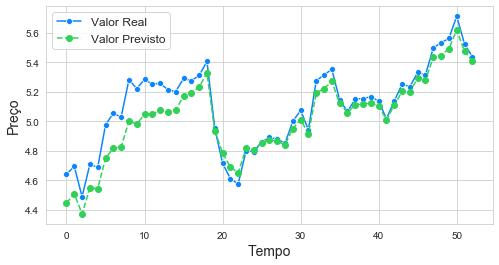

{'alpha': 1, 'gamma': 1}
[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0]


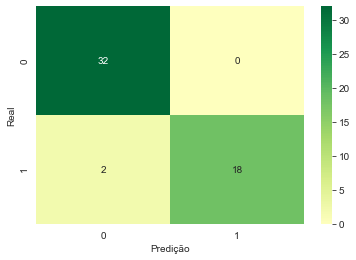

F1 score:  0.9473684210526316
Precision score:  1.0
Accuracy score:  0.9615384615384616
MAE score:  0.07243361923993466
MSE value:  0.009346023082614788
RMSE value:  0.09667483169168069
MAPE value:  0.4490064218059876


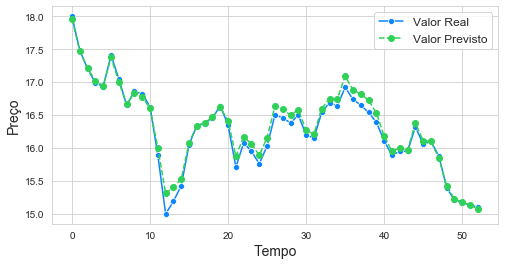

{'alpha': 1, 'gamma': 1}
[1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]
[0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]


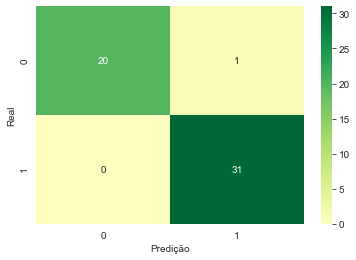

F1 score:  0.9841269841269841
Precision score:  0.96875
Accuracy score:  0.9807692307692307
MAE score:  0.27333777112814783
MSE value:  0.11986150546555455
RMSE value:  0.34621020416151016
MAPE value:  0.6643801204708439


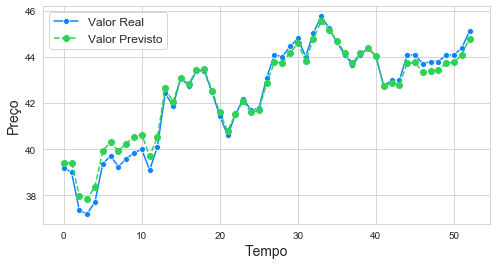

{'alpha': 1, 'gamma': 1}
[1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]
[1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]


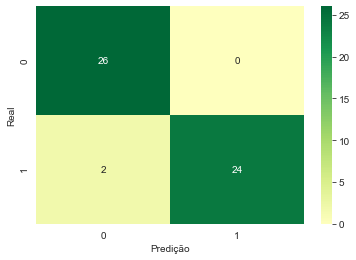

F1 score:  0.9600000000000001
Precision score:  1.0
Accuracy score:  0.9615384615384616
MAE score:  0.19812696764601465
MSE value:  0.05000684191507246
RMSE value:  0.22362209621384121
MAPE value:  0.3648172045965762


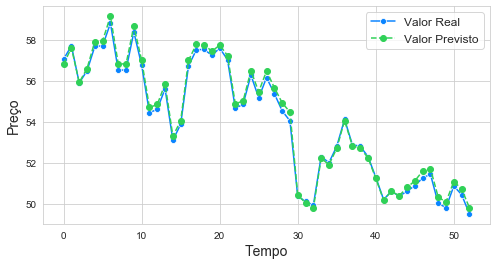

{'alpha': 1, 'gamma': 1}
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0]
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0]


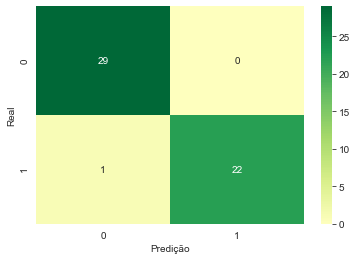

F1 score:  0.9777777777777777
Precision score:  1.0
Accuracy score:  0.9807692307692307
MAE score:  0.419817012604499
MSE value:  0.2909168938366643
RMSE value:  0.5393671234295471
MAPE value:  1.6332890012232335


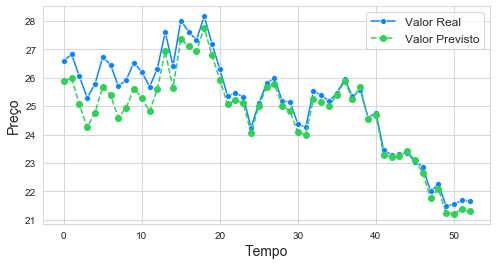

{'alpha': 1, 'gamma': 1}
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0]
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]


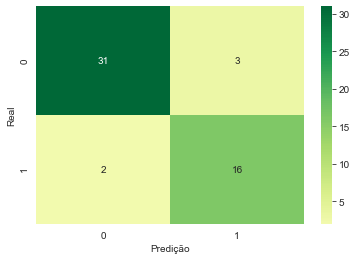

F1 score:  0.8648648648648649
Precision score:  0.8421052631578947
Accuracy score:  0.9038461538461539
MAE score:  0.14894058251891967
MSE value:  0.031113131189316454
RMSE value:  0.1763891470281447
MAPE value:  0.7152608604890558


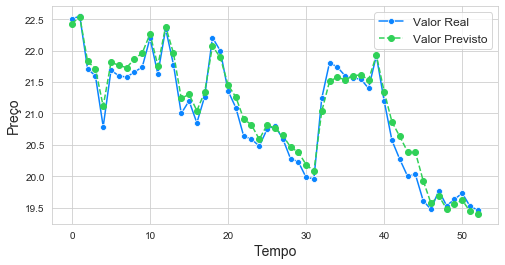

{'alpha': 1, 'gamma': 1}
[0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1]
[0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1]


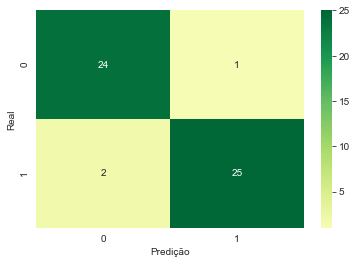

F1 score:  0.9433962264150944
Precision score:  0.9615384615384616
Accuracy score:  0.9423076923076923
MAE score:  0.7401300499290953
MSE value:  0.9378491296630115
RMSE value:  0.9684261095525107
MAPE value:  1.2744689774278064


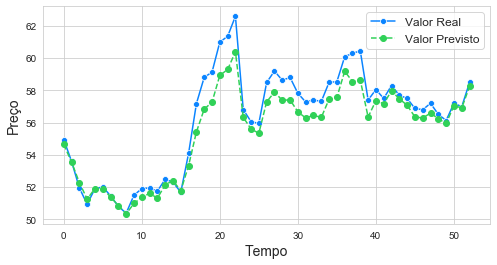

In [246]:
predict_kernel_ridge_all_stocks(historicStock)

<h2><b>Function to predict with Linear Regression</b></h2>

In [247]:
regr = linear_model.LinearRegression()

In [248]:
def predict_linear(stock, stock2, inflation=False):
    print(stock2.shape)
    print(stock.shape)
    stock2 = stock2.rename(columns={"RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
    stock2X = stock2[["rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockX = pd.concat([stockX, stock2X], axis=1)
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [249]:
def predict_linear(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [250]:
def predict_linear_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-1]
        y = y[1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)

        y_pred = y_pred[1:]
        y_test = y_test[:-1]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

    #     print('Coefficients: \n', regr.coef_)

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

[0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0
 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0]
[0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0]


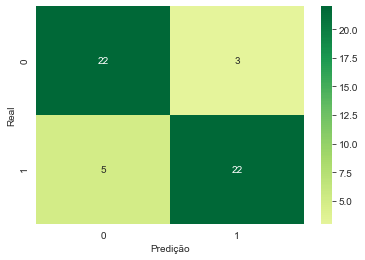

F1 score:  0.8461538461538461
Precision score:  0.88
Accuracy score:  0.8461538461538461
MAE score:  0.13994506777457502
MSE value:  0.03999810674605363
RMSE value:  0.19999526680912633
MAPE value:  0.6749714257759682


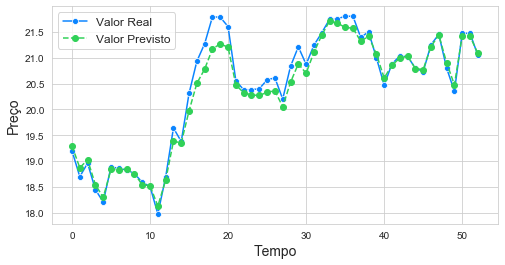

[0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1]
[0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1]


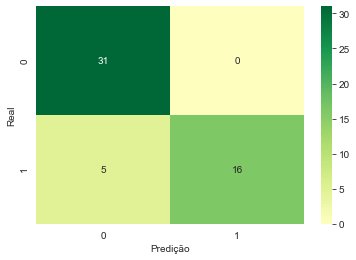

F1 score:  0.8648648648648648
Precision score:  1.0
Accuracy score:  0.9038461538461539
MAE score:  0.03062273402198514
MSE value:  0.001529060696498625
RMSE value:  0.039103205706164615
MAPE value:  1.831843749436271


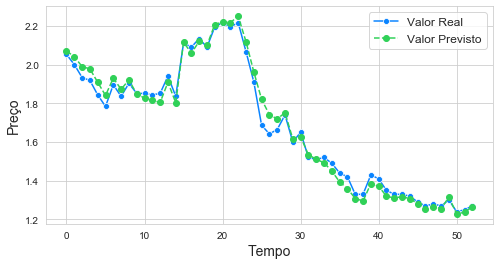

[1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0]
[1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0]


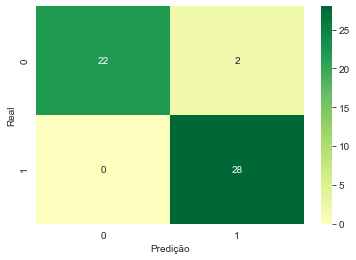

F1 score:  0.9655172413793104
Precision score:  0.9333333333333333
Accuracy score:  0.9615384615384616
MAE score:  0.09184790868493409
MSE value:  0.01285398480931705
RMSE value:  0.11337541536557671
MAPE value:  1.8024829450034479


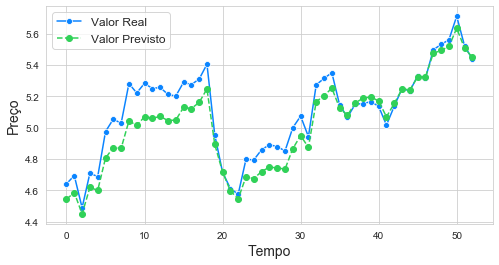

[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0]


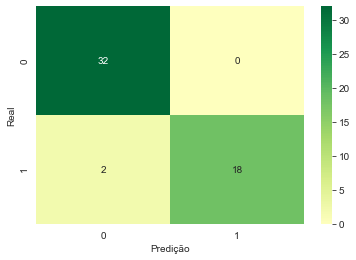

F1 score:  0.9473684210526316
Precision score:  1.0
Accuracy score:  0.9615384615384616
MAE score:  0.06717397019548237
MSE value:  0.0070219424585522
RMSE value:  0.083797031323026
MAPE value:  0.4152010290886172


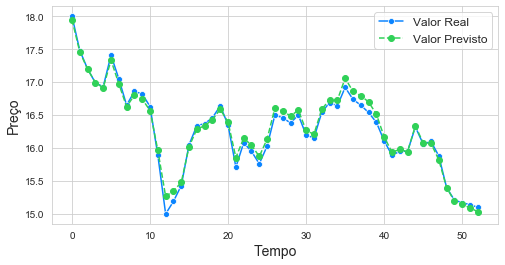

[1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]
[0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]


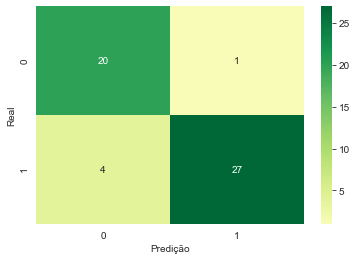

F1 score:  0.9152542372881356
Precision score:  0.9642857142857143
Accuracy score:  0.9038461538461539
MAE score:  0.44246626687499685
MSE value:  0.3214832697450322
RMSE value:  0.5669949468425907
MAPE value:  1.081519179236599


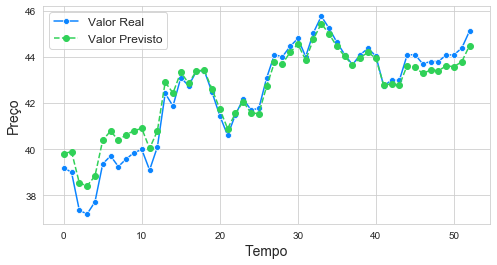

[1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]
[1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0]


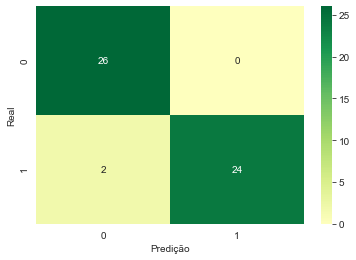

F1 score:  0.9600000000000001
Precision score:  1.0
Accuracy score:  0.9615384615384616
MAE score:  0.18812628904193018
MSE value:  0.04264689218572538
RMSE value:  0.20651123985324715
MAPE value:  0.34840090867144846


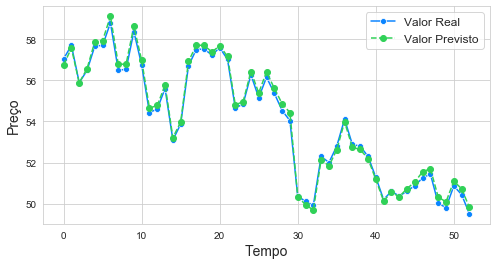

[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0]
[1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0]


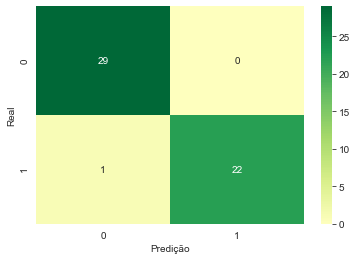

F1 score:  0.9777777777777777
Precision score:  1.0
Accuracy score:  0.9807692307692307
MAE score:  0.4527446853654266
MSE value:  0.3080870574884238
RMSE value:  0.5550559048315978
MAPE value:  1.7683062330508912


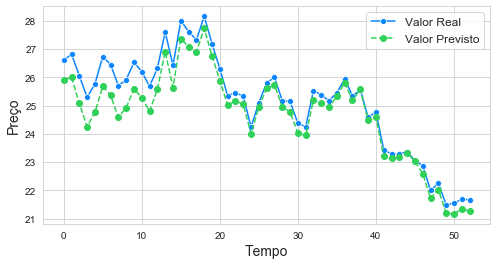

[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0]
[1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]


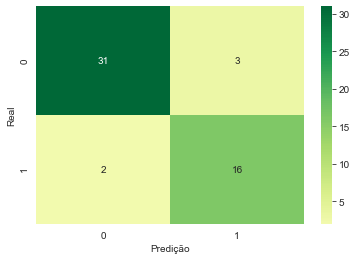

F1 score:  0.8648648648648649
Precision score:  0.8421052631578947
Accuracy score:  0.9038461538461539
MAE score:  0.38075581116296636
MSE value:  0.17245444000138863
RMSE value:  0.41527634173088723
MAPE value:  1.8323826400671952


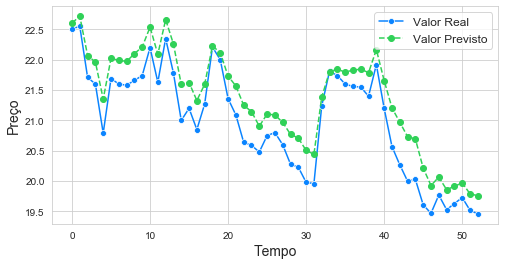

[0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1]
[0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1]


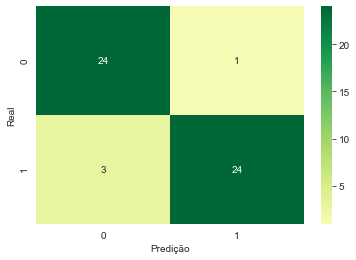

F1 score:  0.923076923076923
Precision score:  0.96
Accuracy score:  0.9230769230769231
MAE score:  0.63544106033613
MSE value:  0.556597898677312
RMSE value:  0.7460548898555066
MAPE value:  1.1618839468391828


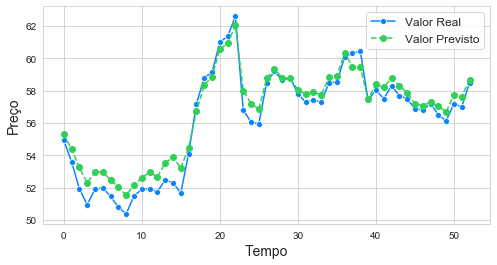

In [251]:
predict_linear_all_stocks(historicStock)